# Part 3: Quantification

In this notebook, we will look at ways to quantitatively characterize objects as they appear in microscopy images. Many different types of measurements can be extracted from images. The ones that are most relevant is ultimately dependent on the underlying biological question. Here, we will look at commonly-used (non-machine-learning) strategies to quantify information that pertains to image intensity and object shape.

In [1]:
import os
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

import warnings
warnings.filterwarnings('ignore')

In [2]:
import skimage as sk
import skimage.measure as skm

In this part, we will use pandas to handle numerical data (https://pandas.pydata.org/). Feel free to consult the extensive documentation available on their website if you want to know more about this library!

In [3]:
import pandas as pd

## 1. Data loading

We will again work with images from the BBBC datasets introduced in notebook 1 - Handling Image Data. 

**1.1** Using what you learned in notebook 1 - Handling Image Data, load the following image files:
- data/Part 3/BBBC010/raw.tif
- data/Part 3/BBBC020/membranes.tif

*Do not forget to convert the images into floating-point arrays with img_as_float!*

In [4]:
# BBBC010
bbbc010 = imageio.imread('data/Part 3/BBBC010/raw.tif')
bbbc010 = sk.img_as_float(bbbc010)

# BBBC020
bbbc020 = imageio.imread('data/Part 3/BBBC020/membranes.tif')
bbbc020 = sk.img_as_float(bbbc020)

**1.2** To help us with the quantification, we also have instance segmentation masks provided for each image in a folder called "instances". Run the lines below to load these masks into an array.

In [5]:
# BBBC010
bbbc010_instances = {}
idx = 0
for file in os.listdir('data/Part 3/BBBC010/instances'):
    if file.endswith(".png"):
        im = imageio.imread(os.path.join('data/Part 3/BBBC010/instances',file))
        bbbc010_instances[idx] = im
        idx+=1
                            
# BBBC020
bbbc020_instances = {}
idx = 0
for file in os.listdir('data/Part 3/BBBC020/instances'):
    if file.endswith(".TIF"):
        im = imageio.imread(os.path.join('data/Part 3/BBBC020/instances',file))
        bbbc020_instances[idx] = im
        idx+=1

## 2. Intensity-based measurements

The most direct measurements one can make are those based on pixel values. When dealing with raw (unprocessed) images, pixel values are related to the amount of light (photons) that reached the camera during the acquisition process - although the exact nature of this relationship may be quite complicated. 

**2.1** The BBBC020 image corresponds to the signal of a fluorescently-tagged cell-surface protein (CD11b/APC). Run the code below to extract some statistics about the intensity distributions for each objects in the image using the provided instance segmentation masks. Are the results surprising? 

In [6]:
# Extract intensity features
bbbc020_intensity_feats = []
for idx in bbbc020_instances.keys():
    mask = bbbc020_instances[idx]
    
    intensities = bbbc020[mask>0] 
    median = np.median(intensities)
    std = np.std(intensities)
    
    bbbc020_intensity_feats.append([median, std])
    
bbbc020_intensity_feats = pd.DataFrame(bbbc020_intensity_feats, columns=['Median', 'Standard Deviation'])
bbbc020_intensity_feats.index.name = 'Instance ID'

display(bbbc020_intensity_feats)

,Median,Standard Deviation
Instance ID,,
0,0.345098,0.120066
1,0.196078,0.099066
2,0.074510,0.029529
3,0.247059,0.086385
4,0.254902,0.115411
5,0.211765,0.094922
6,0.176471,0.076295
7,0.090196,0.039847
8,0.349020,0.137951


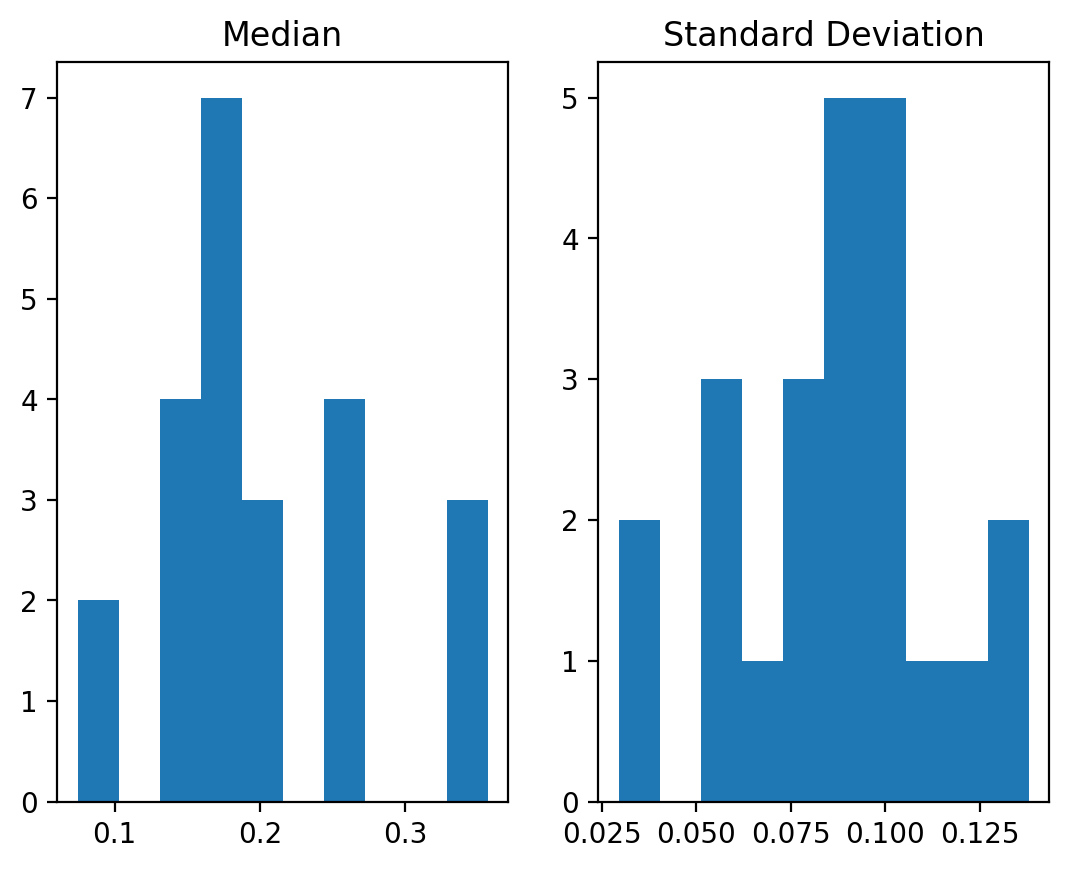

In [7]:
# Visualize the distribution of each feature as an histogram
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].hist(bbbc020_intensity_feats['Median'].values) 
# Cells tend to have similar median intensity...
axes[0].set_title('Median')

axes[1].hist(bbbc020_intensity_feats['Standard Deviation'].values)  
# ...but there is a lot of different intensity variation patterns! 
axes[1].set_title('Standard Deviation')

plt.show()

**2.2** The BBBC010 image is a brightfield view of *C. elegans* worms treated with an antibiotic. The worms are also stained with a fluorescent protein that specifically targets dead animals. Run the code below to load the fluorescence microscopy readout, and adapt the code from 2.1 to study the population of worms in the BBBC010 image. Can you spot the dead worms?

In [8]:
# Load fluorescence readout
bbbc010_fluo = imageio.imread('data/Part 3/BBBC010/fluorescence.tif')
bbbc010_fluo = sk.img_as_float(bbbc010_fluo)

In [9]:
# Extract intensity features from fluorescence readout
# Subtract background
bbbc010_fluo = bbbc010_fluo - np.median(bbbc010_fluo)

# Extract median intensity
bbbc010_intensity_feats = []
for idx in bbbc010_instances.keys():
    mask = bbbc010_instances[idx]
    
    intensities = bbbc010_fluo[mask>0] 
    median = np.median(intensities)
    std = np.std(intensities)

    bbbc010_intensity_feats.append([median, std])
    
bbbc010_intensity_feats = pd.DataFrame(bbbc010_intensity_feats, columns=['Median', 'Standard Deviation'])
bbbc010_intensity_feats.index.name = 'Instance ID'

display(bbbc010_intensity_feats)

,Median,Standard Deviation
Instance ID,,
0,0.000214,0.000097
1,0.000183,0.000077
2,0.000122,0.000160
3,0.000214,0.000322
4,0.000916,0.000622
5,0.000412,0.000283
6,0.000183,0.000078
7,0.000168,0.000068
8,0.000183,0.000071


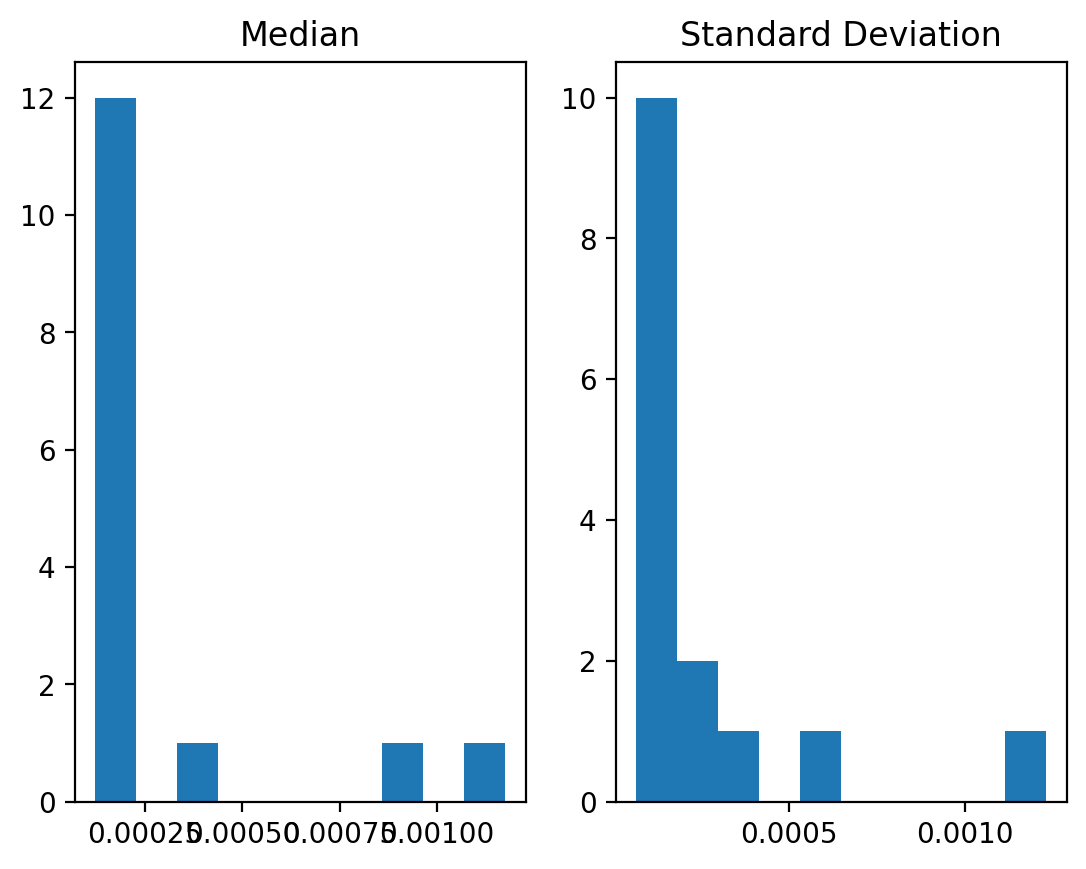

In [10]:
# Visualize the distribution of each feature as an histogram
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].hist(bbbc010_intensity_feats['Median'].values) 
# There are 3 clear outliers!
axes[0].set_title('Median')

axes[1].hist(bbbc010_intensity_feats['Standard Deviation'].values)  
axes[1].set_title('Standard Deviation')

plt.show()

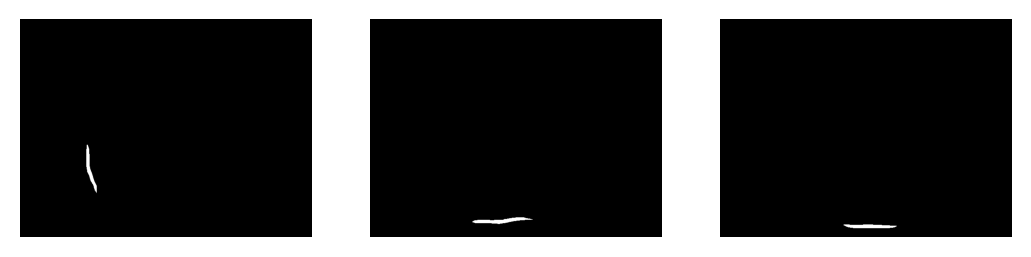

In [11]:
# Worms number 4, 5 and 9 seem to be very dead :(
fig, axes = plt.subplots(nrows=1, ncols=3)

axes[0].imshow(bbbc010_instances[4], cmap='gray')
axes[0].axis('off')

axes[1].imshow(bbbc010_instances[5], cmap='gray')
axes[1].axis('off')

axes[2].imshow(bbbc010_instances[9], cmap='gray')
axes[2].axis('off')

plt.show()

## 3. Shape-based measurements

In addition to the intensity of pixels within them, the shape of objects in images can hold relevant information. Shape is generally challenging to quantify with a single number, but can be reasonably characterized with collections of descriptors as we shall see.

**3.1** The most classical and direct way of characterizing shape is to rely on collection of measurements referred to as *region properties*. Run the code below to extract a subset of scikit-image's own collection of region properties on the BBBC020 image. Their definition is provided at https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops . Do you understand which aspect of the shape they capture?

Below, you will also find a piece of code that colors instances in the image according to the value of a shape property of your choice. Play around with it to get an intuition of what these different metrics reveal.

In [12]:
# Extract shape features
bbbc020_shape_feats = []
for idx in bbbc020_instances.keys():
    mask = bbbc020_instances[idx]
    
    all_props = skm.regionprops(mask)[0]
    bbbc020_shape_feats.append([all_props['area'], all_props['perimeter'], all_props['axis_major_length'],
                        all_props['axis_minor_length'], all_props['eccentricity'], all_props['solidity'],
                        all_props['extent']])

bbbc020_shape_feats = pd.DataFrame(bbbc020_shape_feats, columns=['Area', 'Perimeter', 'Major axis', 'Minor axis',
                                                 'Eccentricity', 'Solidity', 'Extent'])
bbbc020_shape_feats.index.name = 'Instance ID'

display(bbbc020_shape_feats)

,Area,Perimeter,Major axis,Minor axis,Eccentricity,Solidity,Extent
Instance ID,,,,,,,
0,12383,443.847763,152.329270,106.702644,0.713678,0.977040,0.732765
1,30665,948.063059,291.980432,147.814205,0.862389,0.807930,0.581603
2,29778,965.193001,299.743228,146.324753,0.872750,0.762717,0.505089
3,10038,397.404112,121.127046,108.104134,0.451076,0.956273,0.693328
4,23872,877.251875,230.878641,174.451174,0.655037,0.725020,0.438566
5,47667,928.075252,285.233292,219.382347,0.639089,0.935785,0.668167
6,33177,910.726009,368.676939,125.499176,0.940279,0.815821,0.459261
7,47650,913.015331,263.246661,234.689608,0.452982,0.936186,0.690850
8,13413,543.031529,197.189116,92.569171,0.882962,0.911271,0.639079


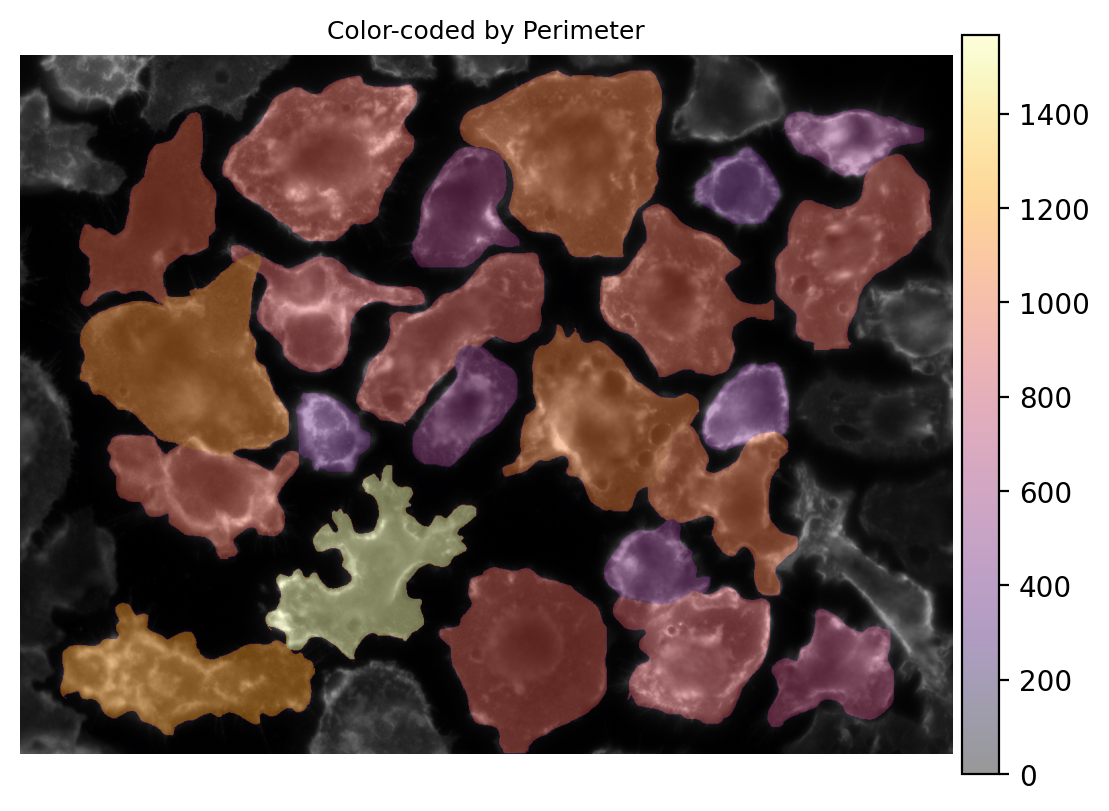

In [13]:
# Label objects according to a property of your choice
feature = 'Perimeter'

feature_mask = np.zeros(bbbc020.shape)
for idx in bbbc020_instances.keys():
    mask = bbbc020_instances[idx]
    
    feature_val = bbbc020_shape_feats.loc[idx, feature]
    feature_mask[np.where(mask)] = feature_val

plt.imshow(bbbc020, cmap='gray')
im = plt.imshow(feature_mask, cmap='inferno', alpha=.4)
plt.colorbar(im, fraction=0.05, pad=0.01)
plt.axis('off')
plt.title('Color-coded by '+feature, fontsize=9)
plt.show()

**3.2** As an alternative to individual independent measurements as exactred from region propertiers, one can summarize a shape by the coefficients of its decomposition into an orthonormal basis. This is the idea behind Fourier descriptors (https://en.wikipedia.org/wiki/Fourier_analysis), implemented in the pyefd library (https://github.com/hbldh/pyefd).

In [14]:
import pyefd

Although the technical details of Fourier analysis is beyond the scope of this course, we can get a visual intuition of how that works. Run the code below to 1) decompose the shape of one of the objects in the BBBC020 image in the Fourier basis, 2) visualize its N-term approximation. By varying N, can you get a sense of how information is distributed across Fourier coefficients?

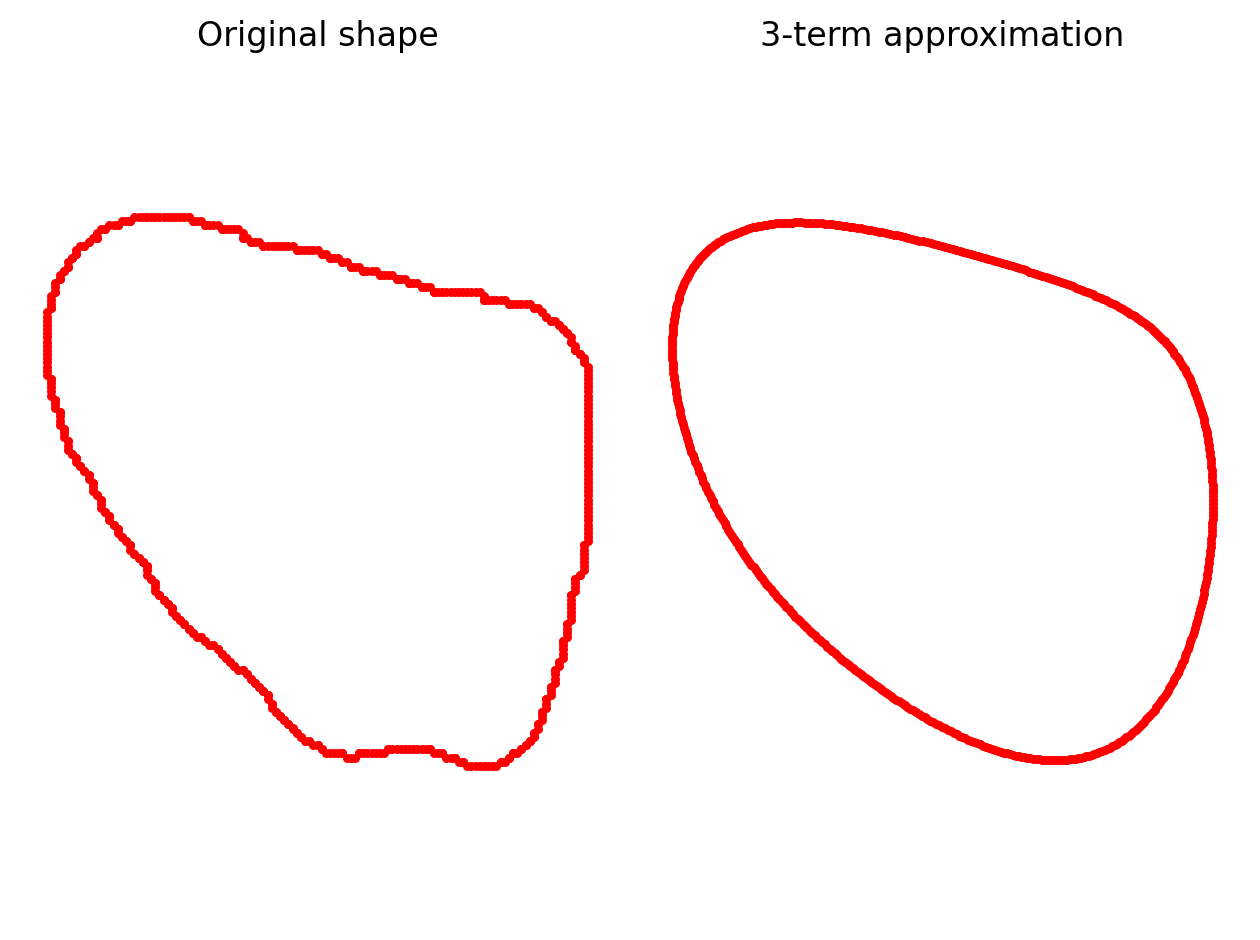

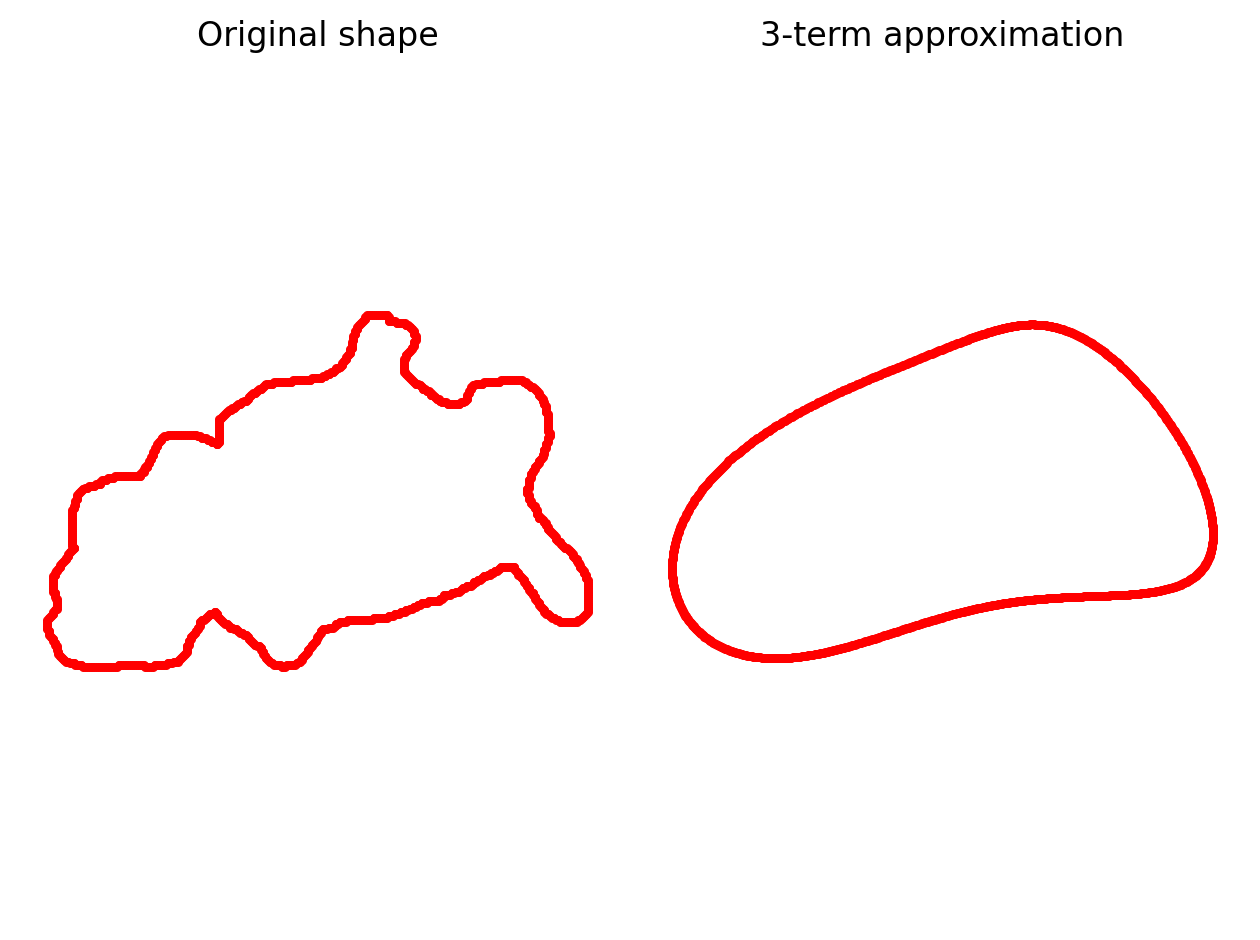

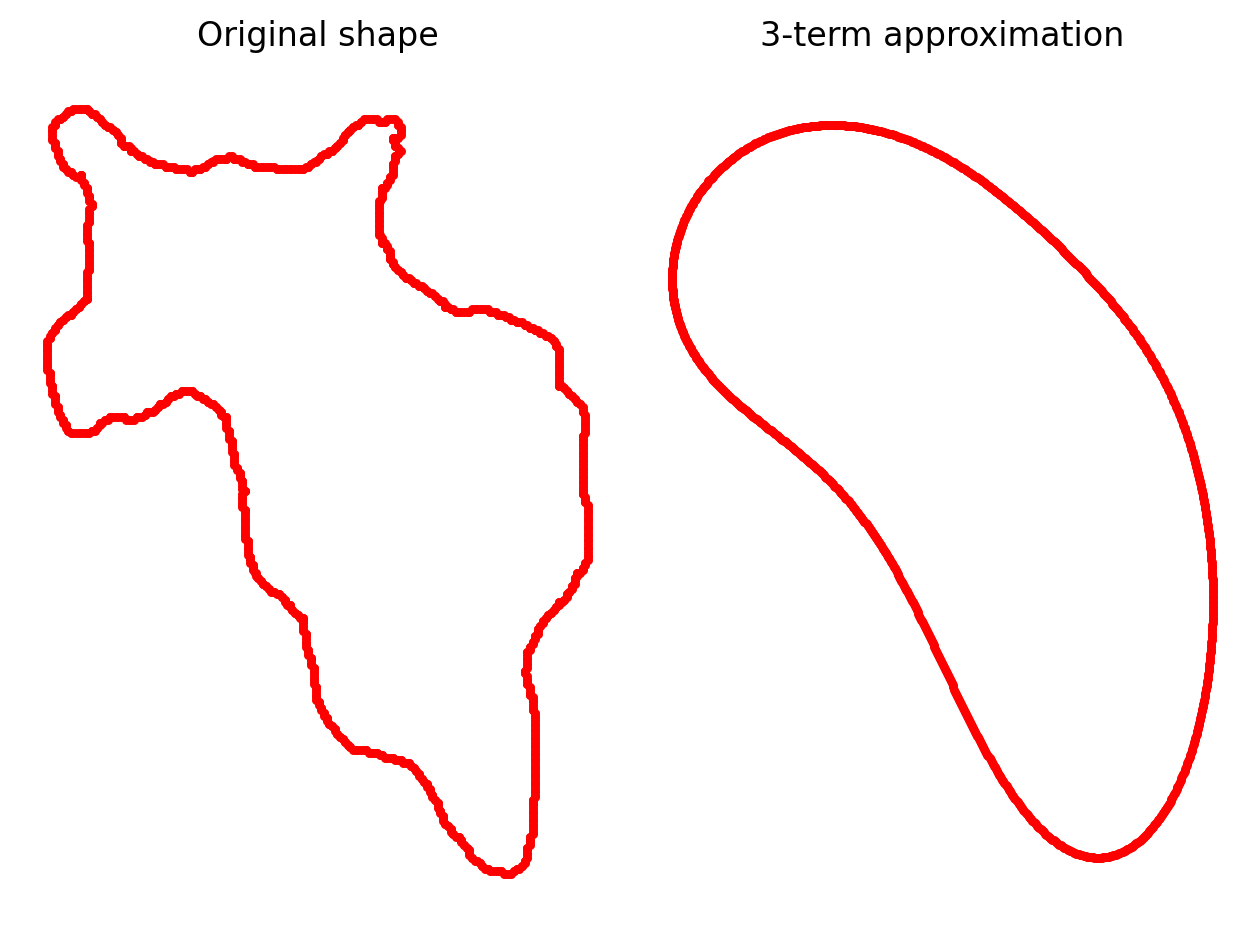

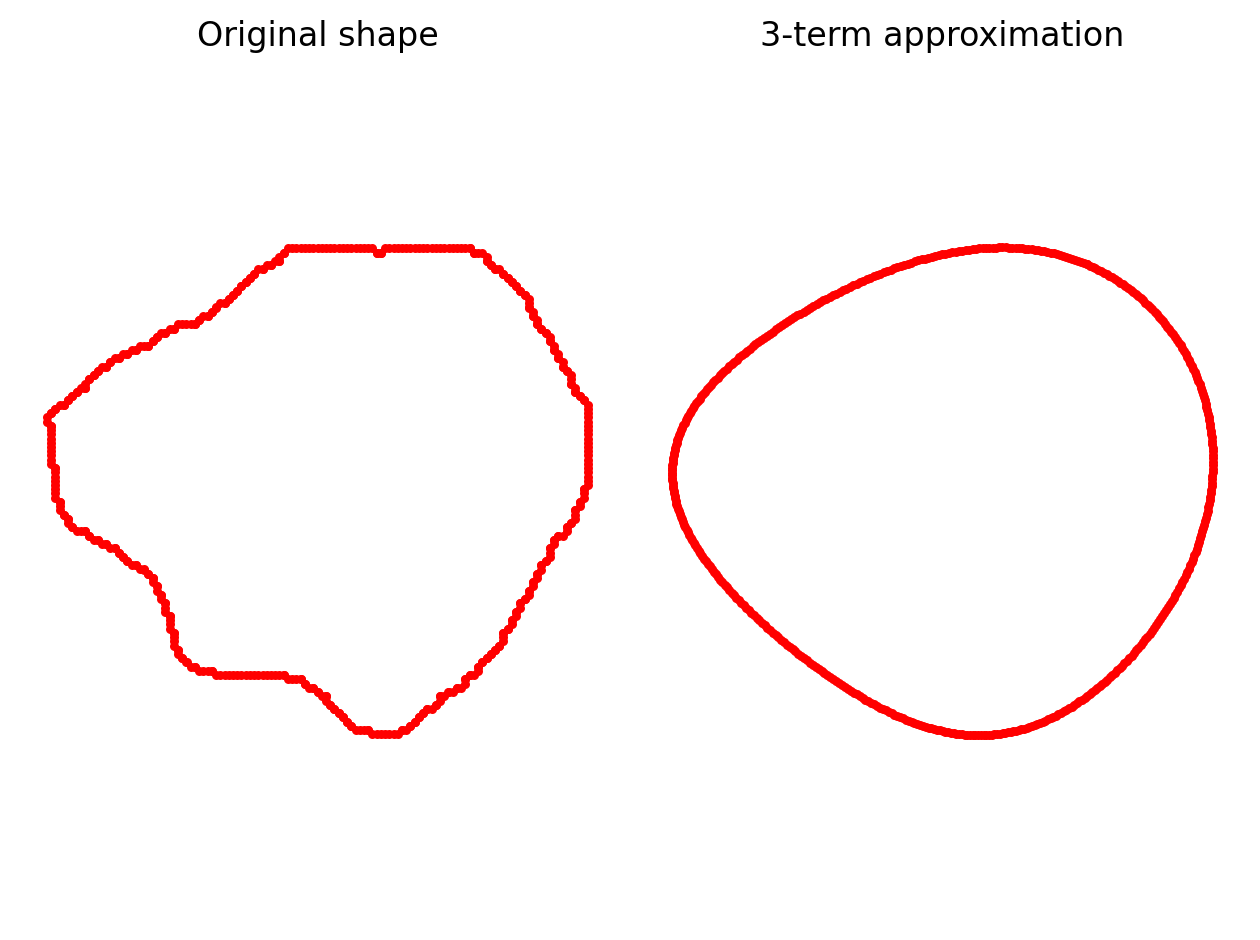

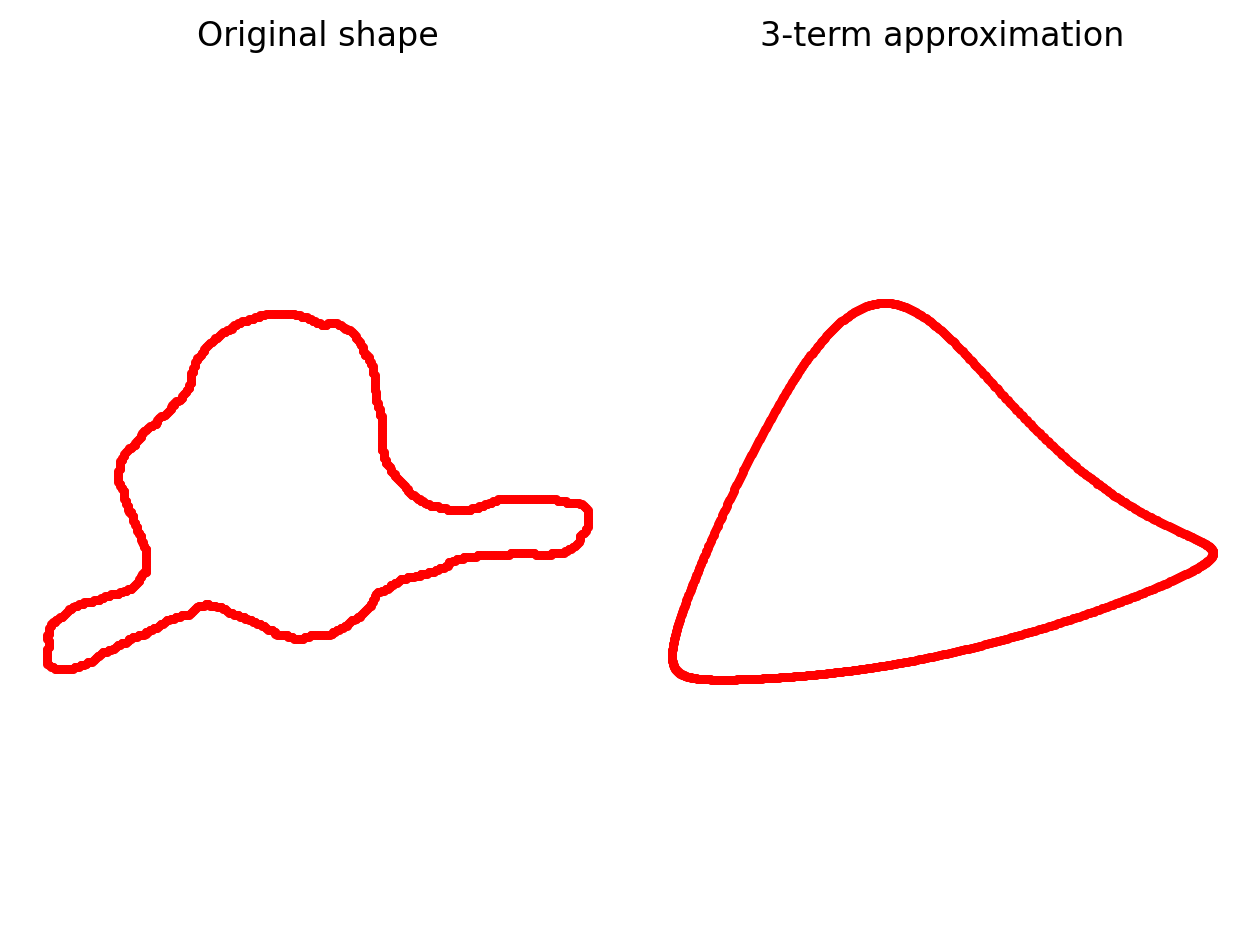

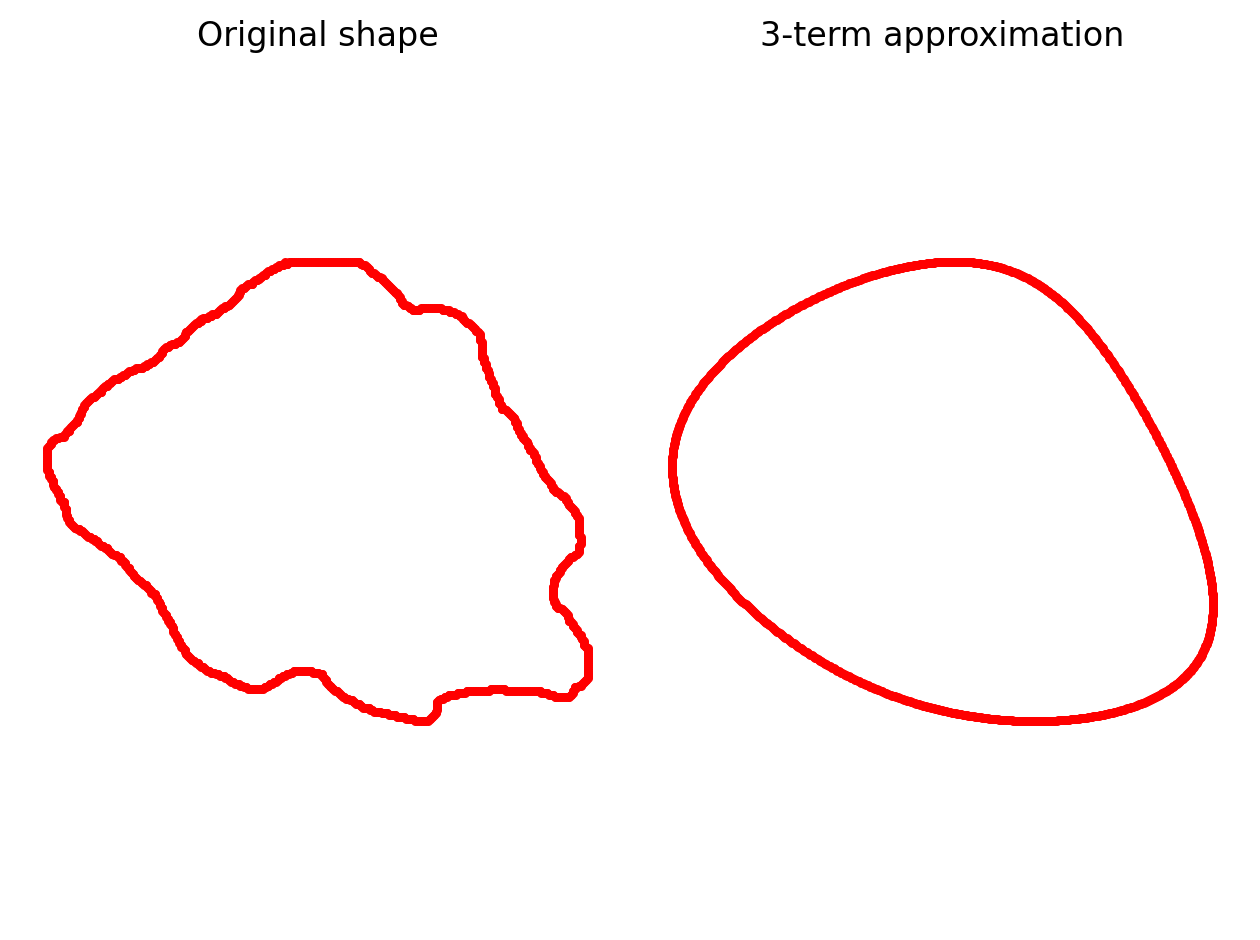

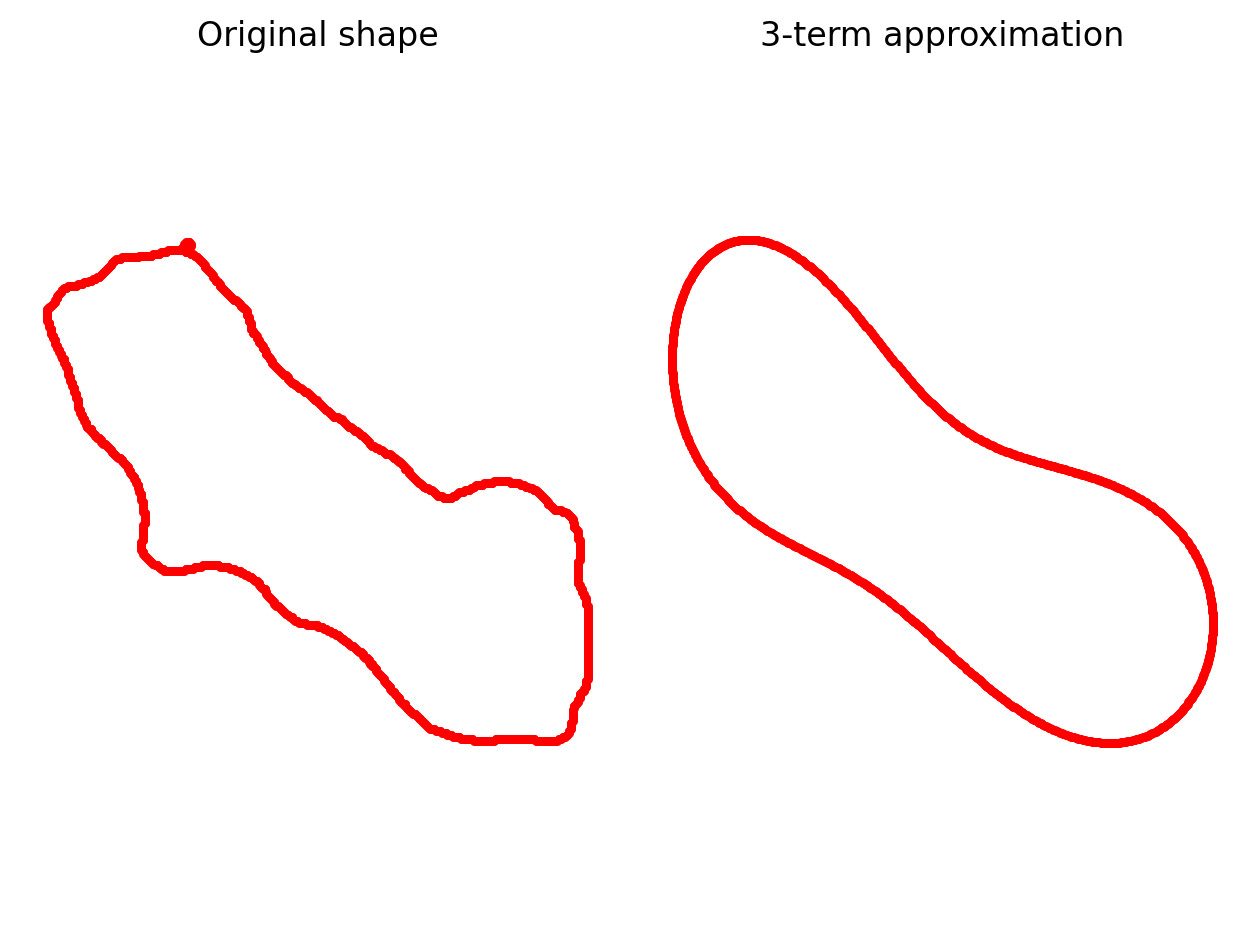

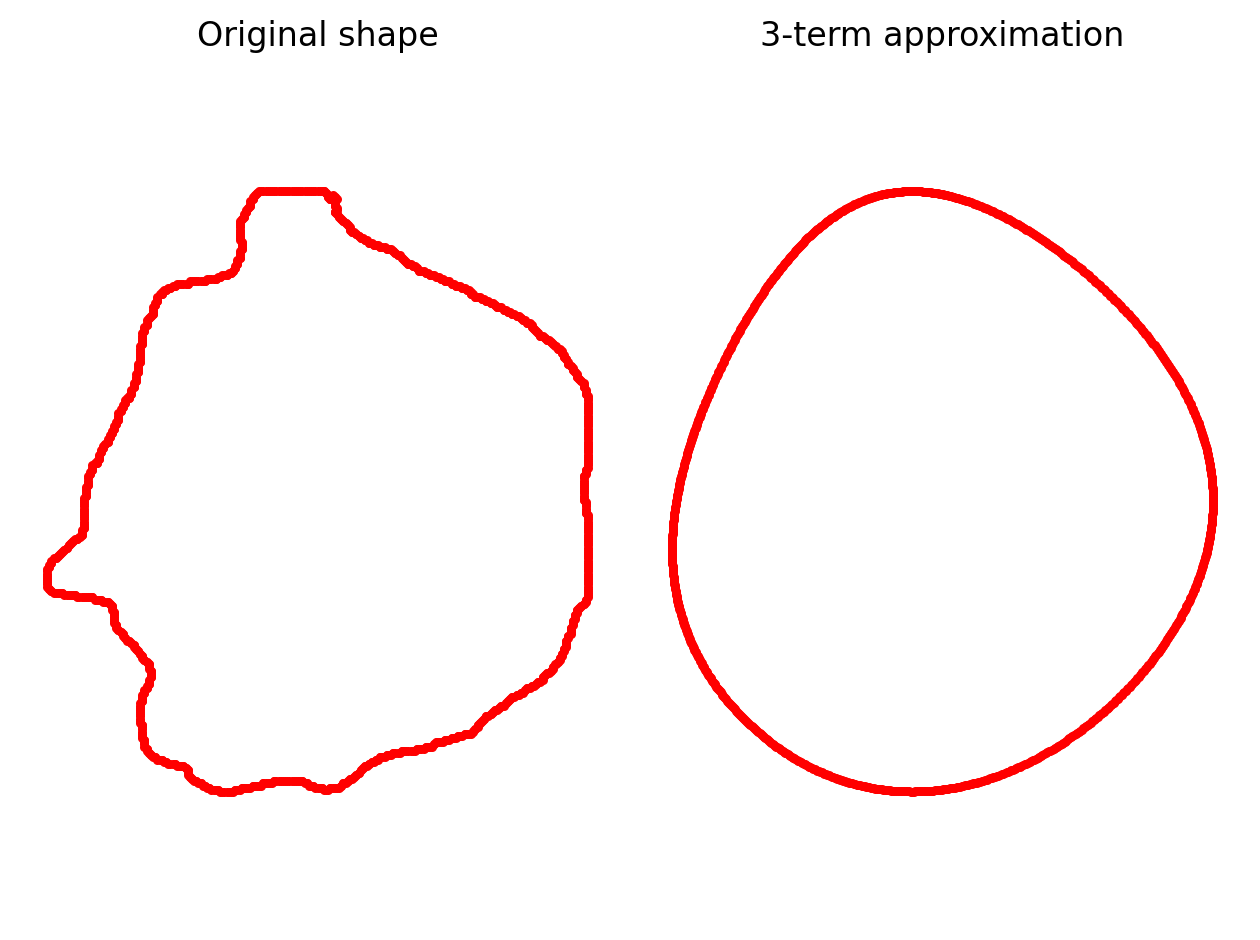

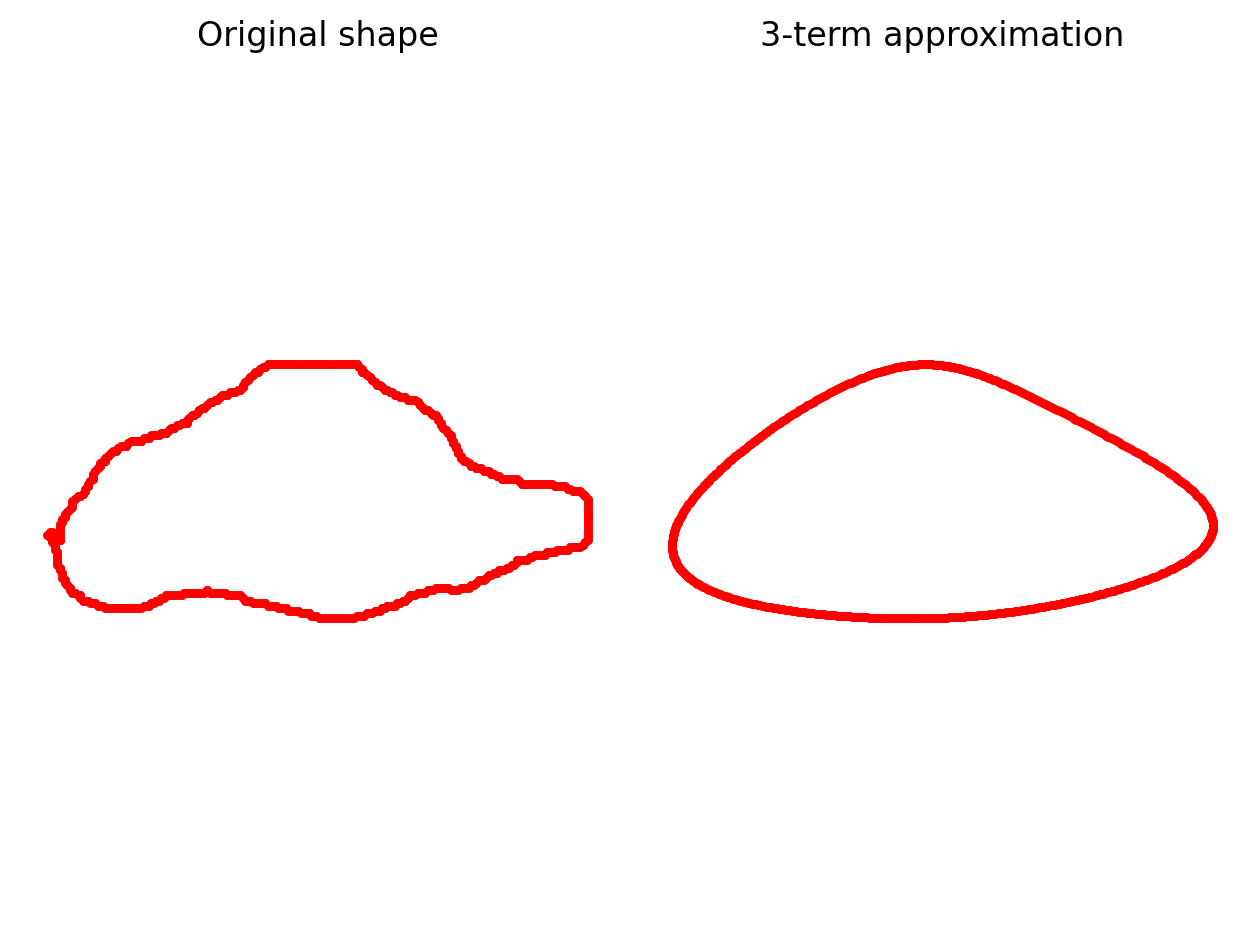

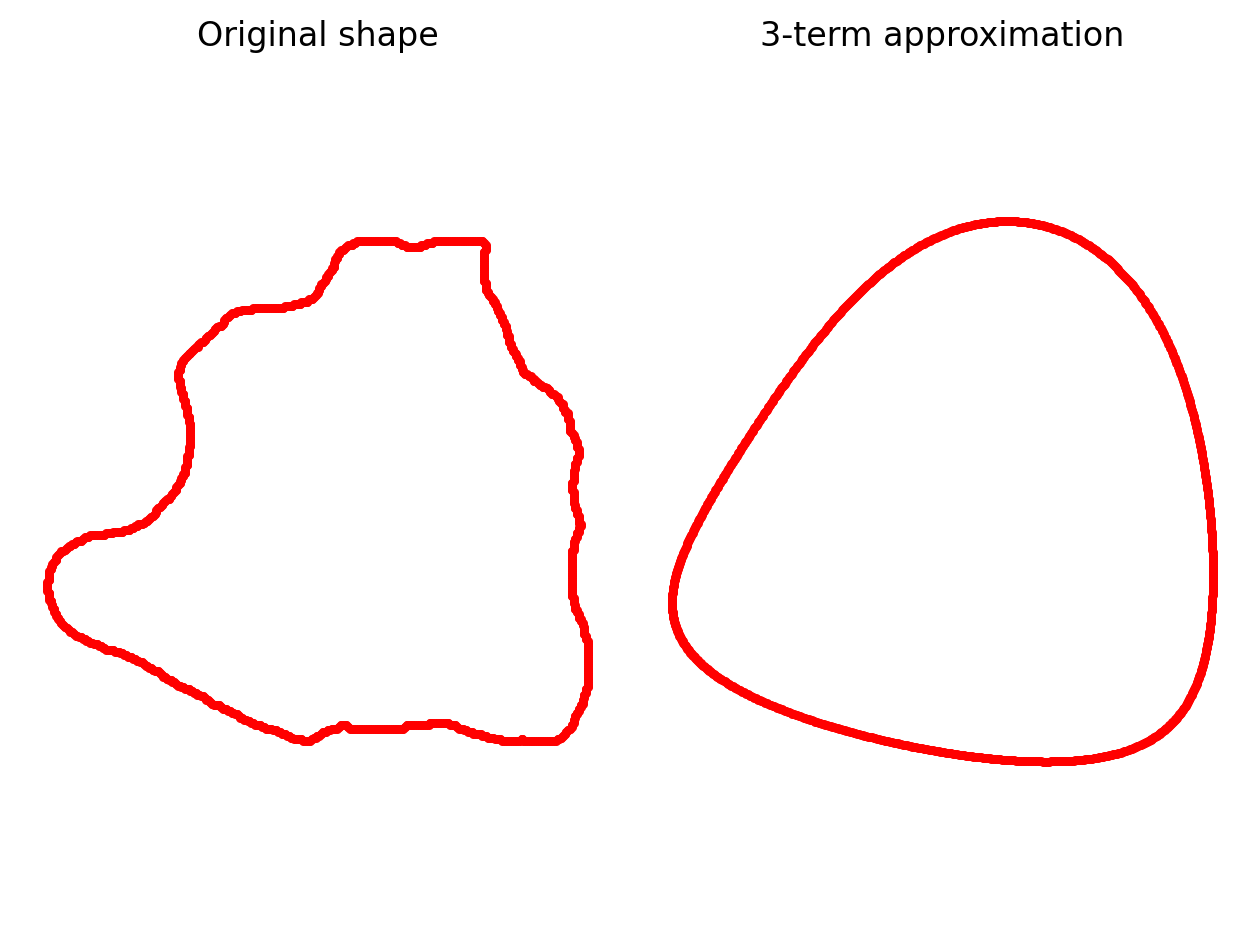

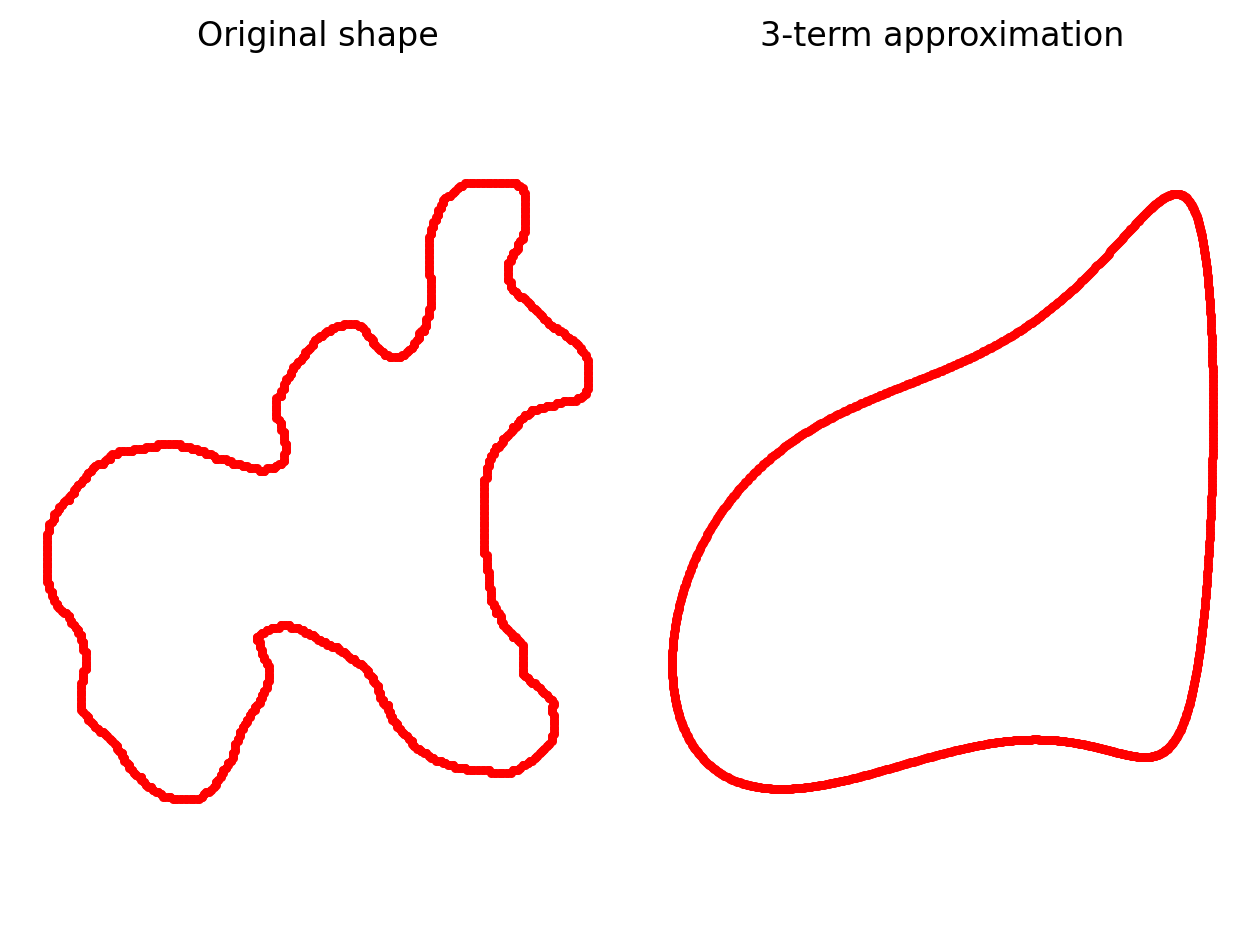

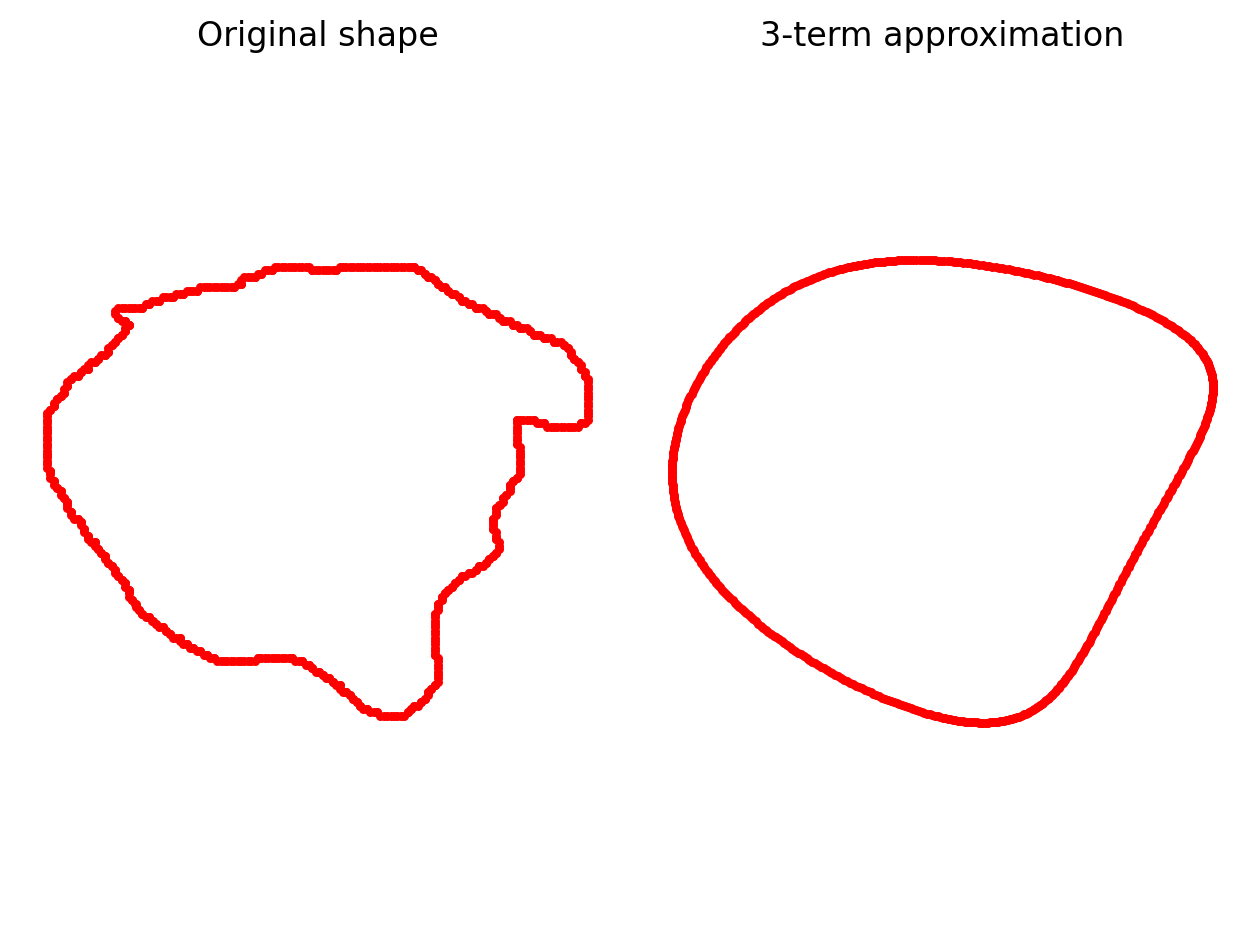

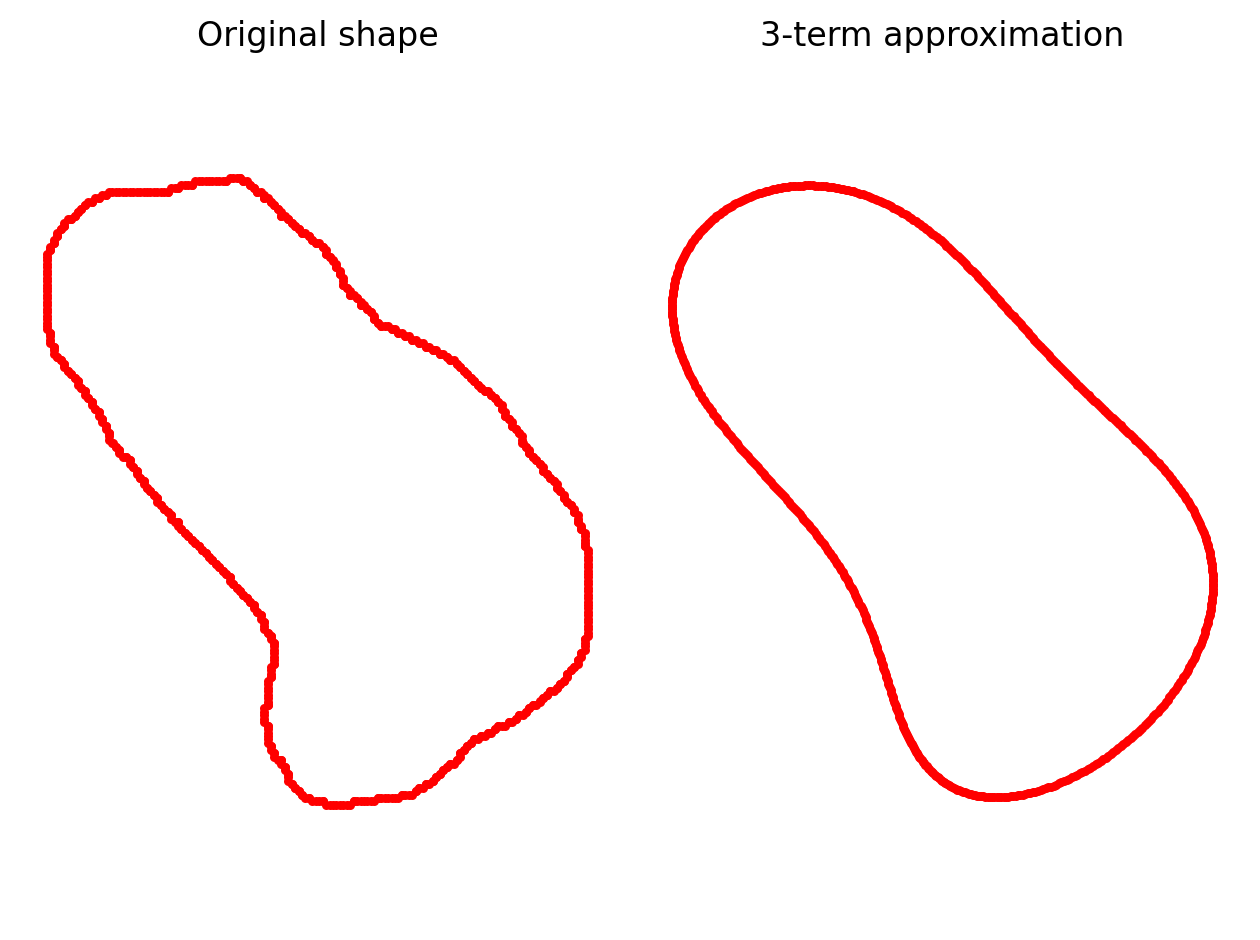

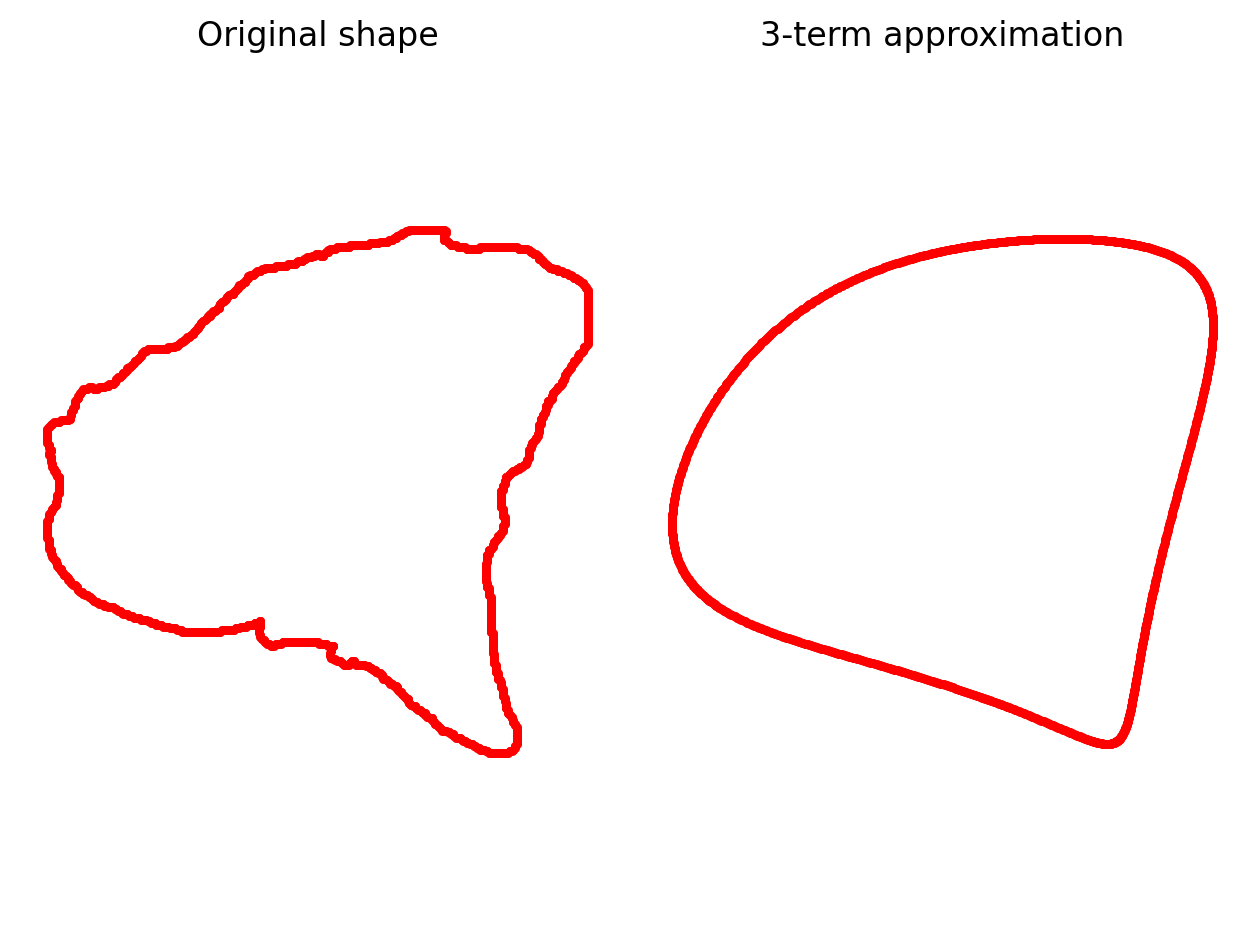

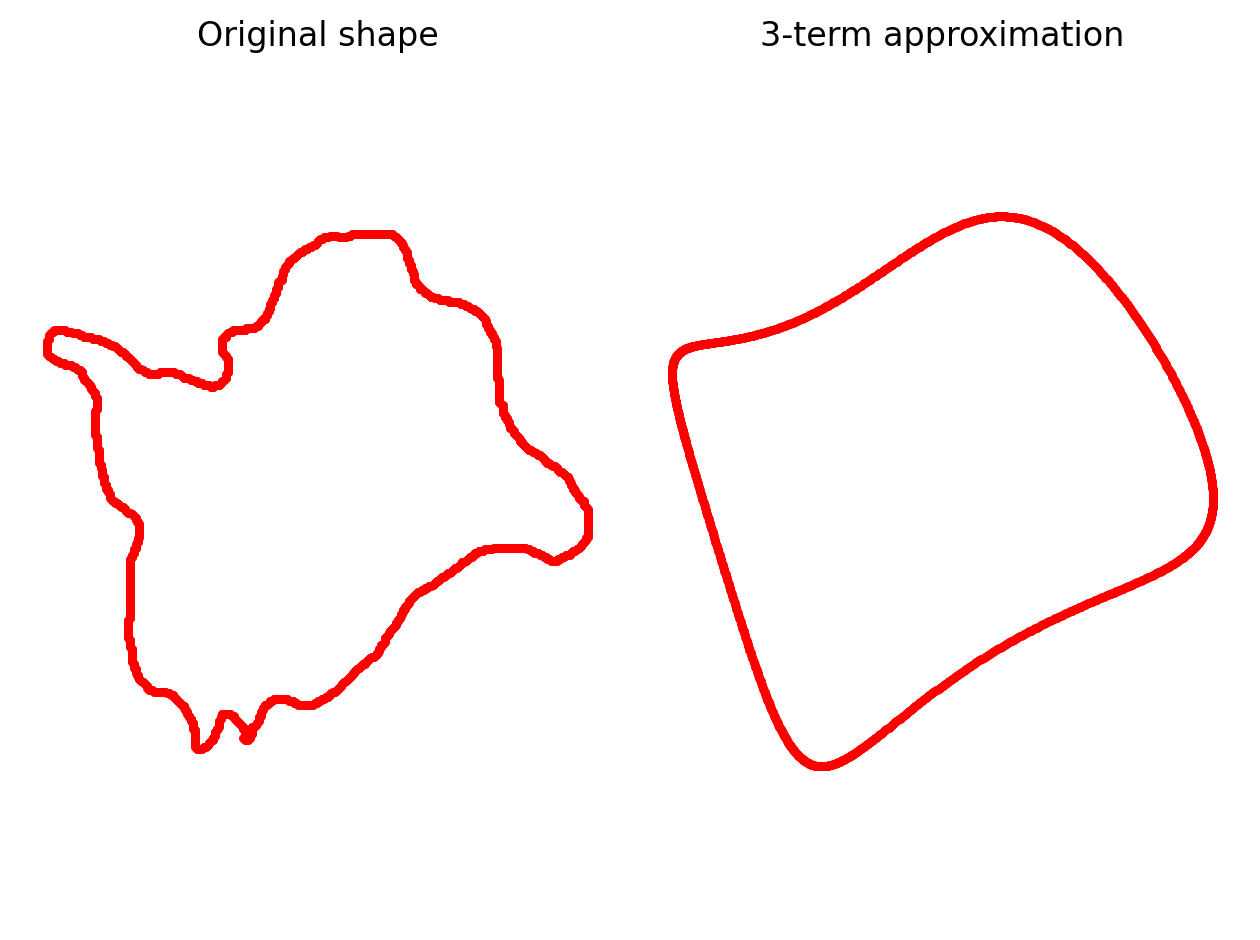

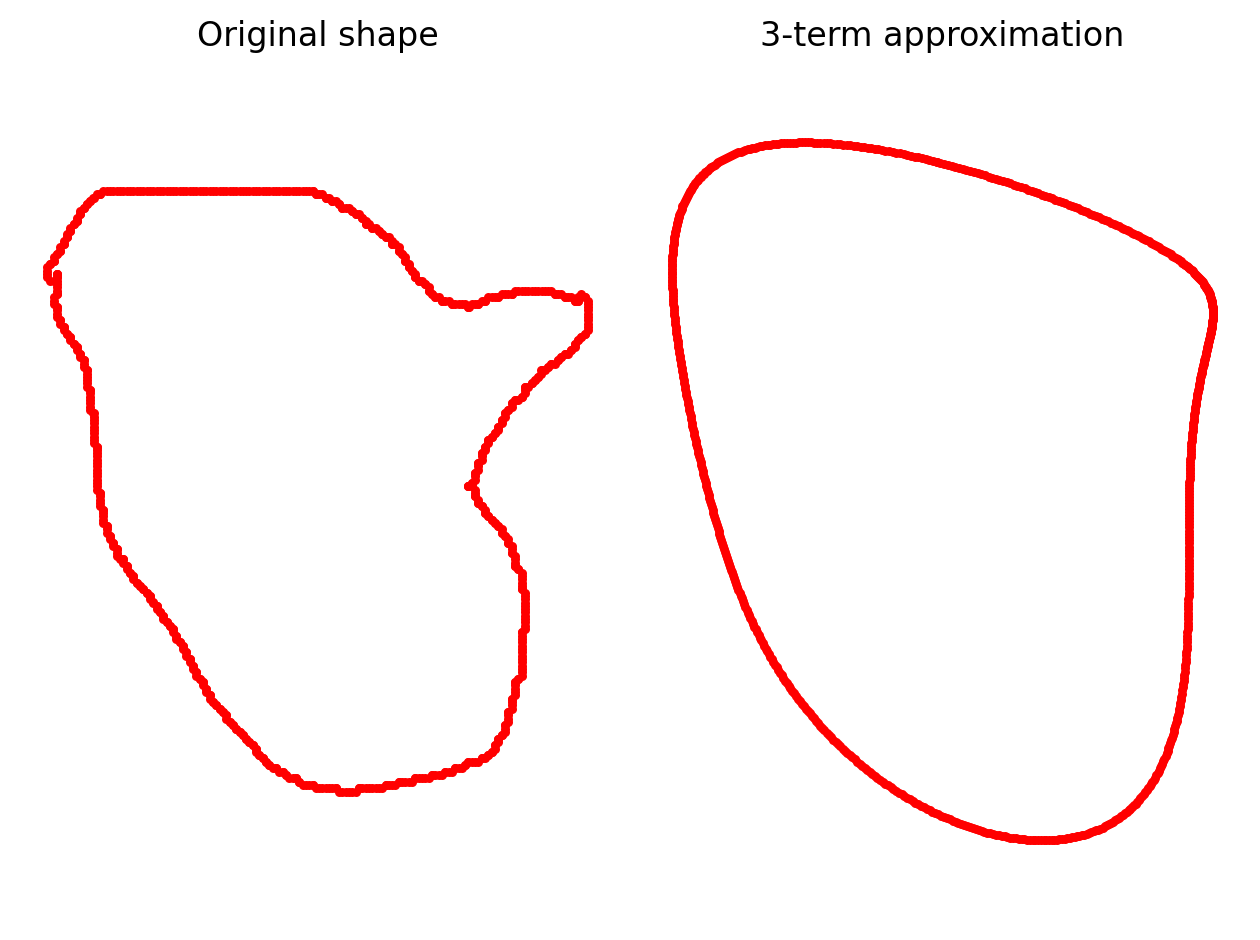

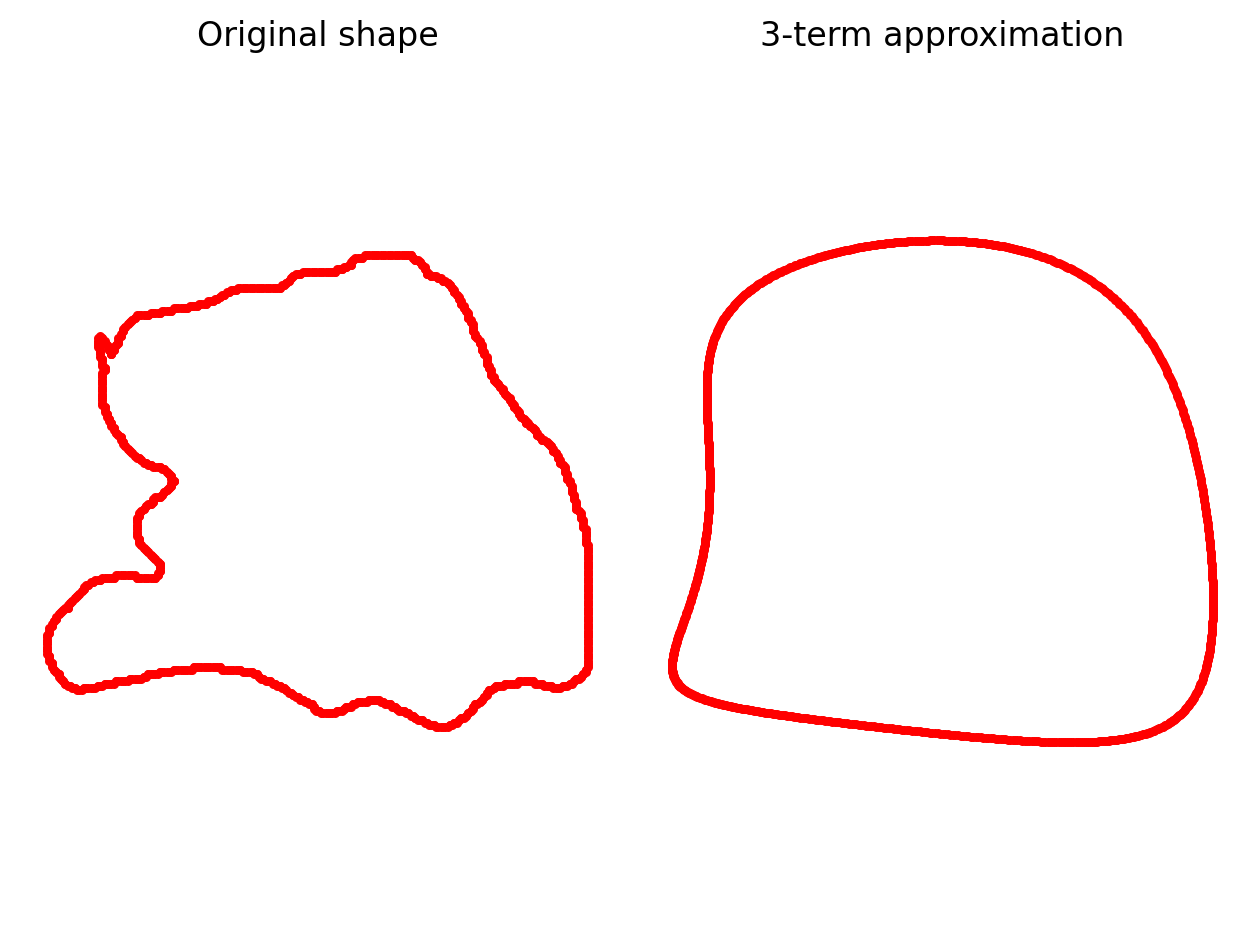

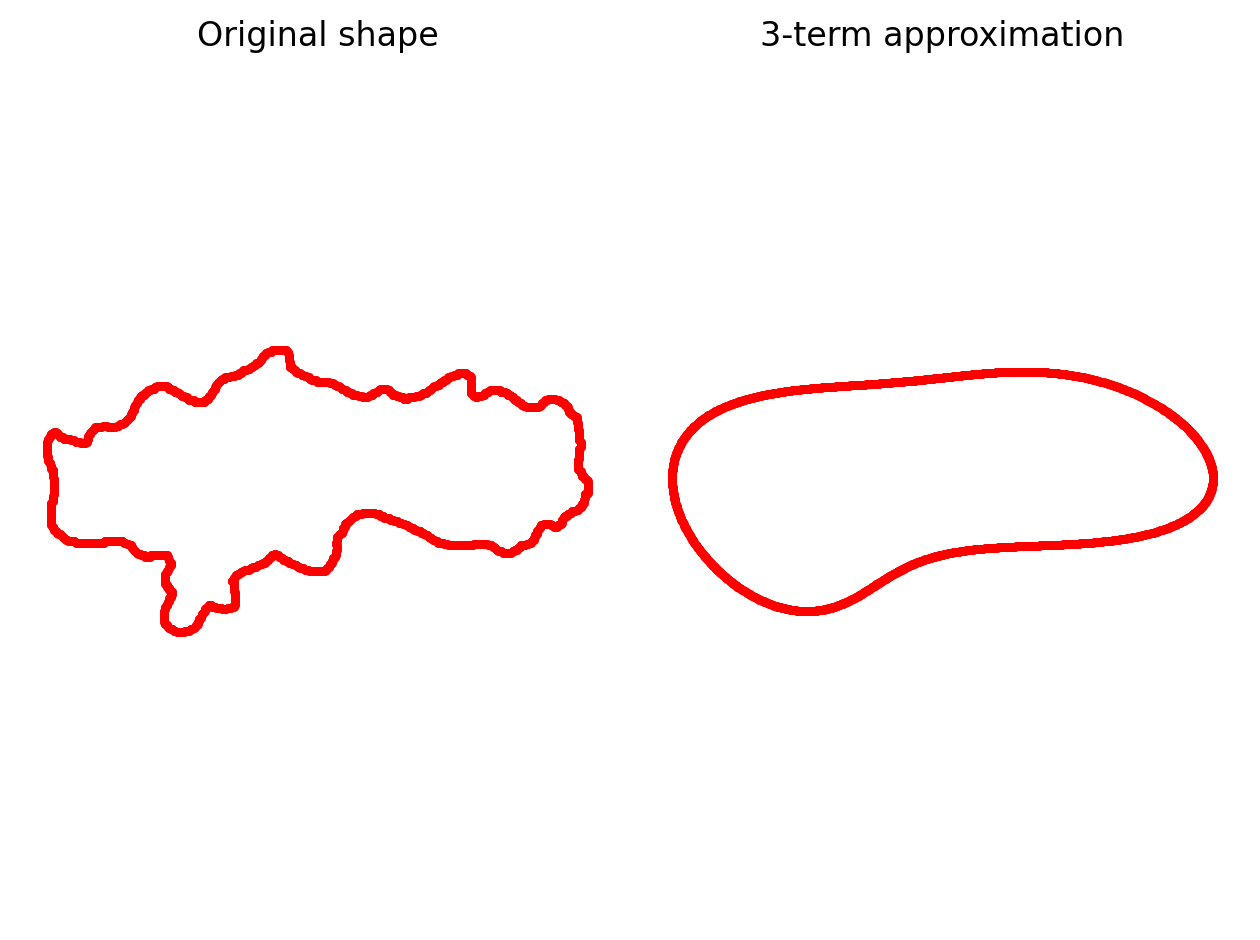

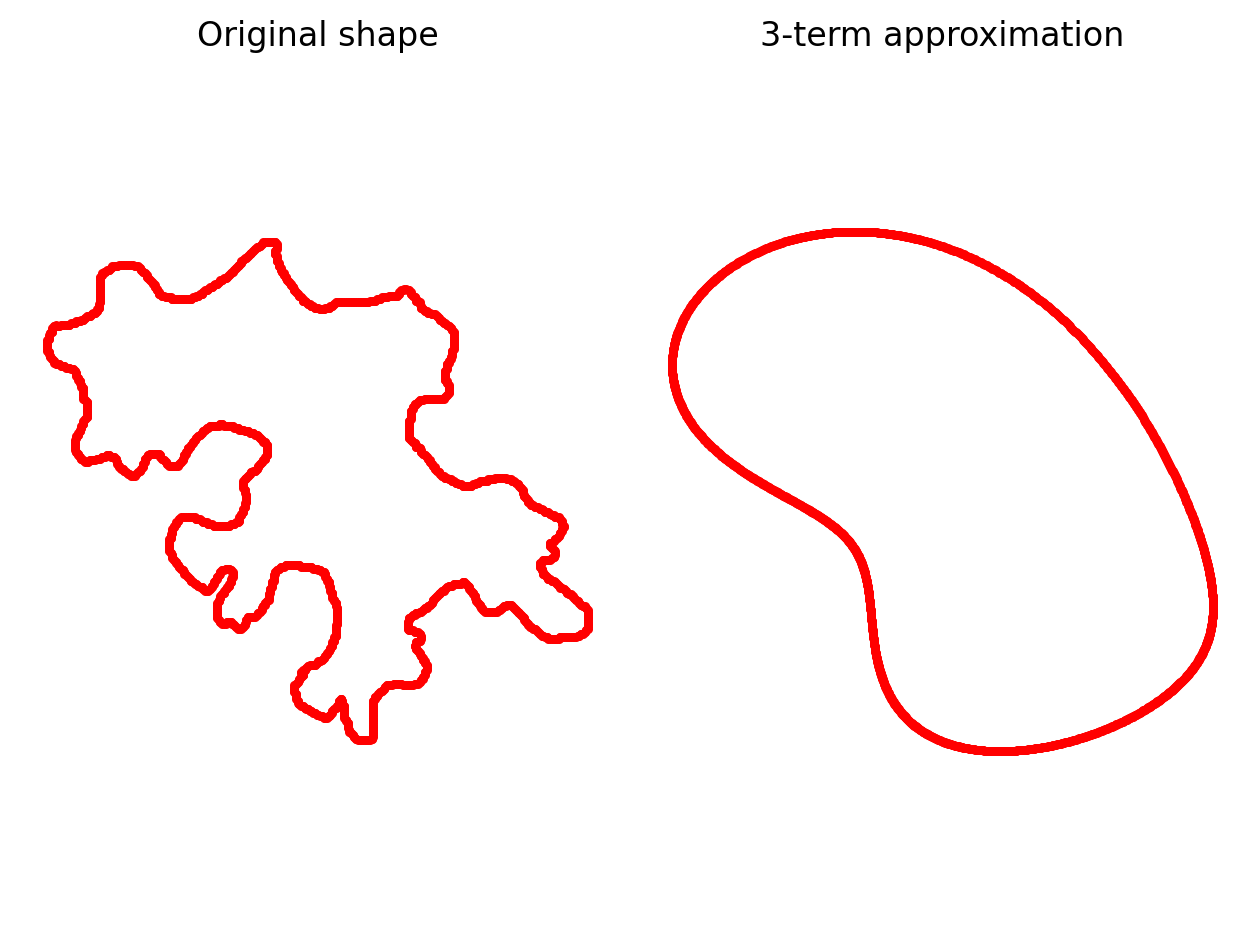

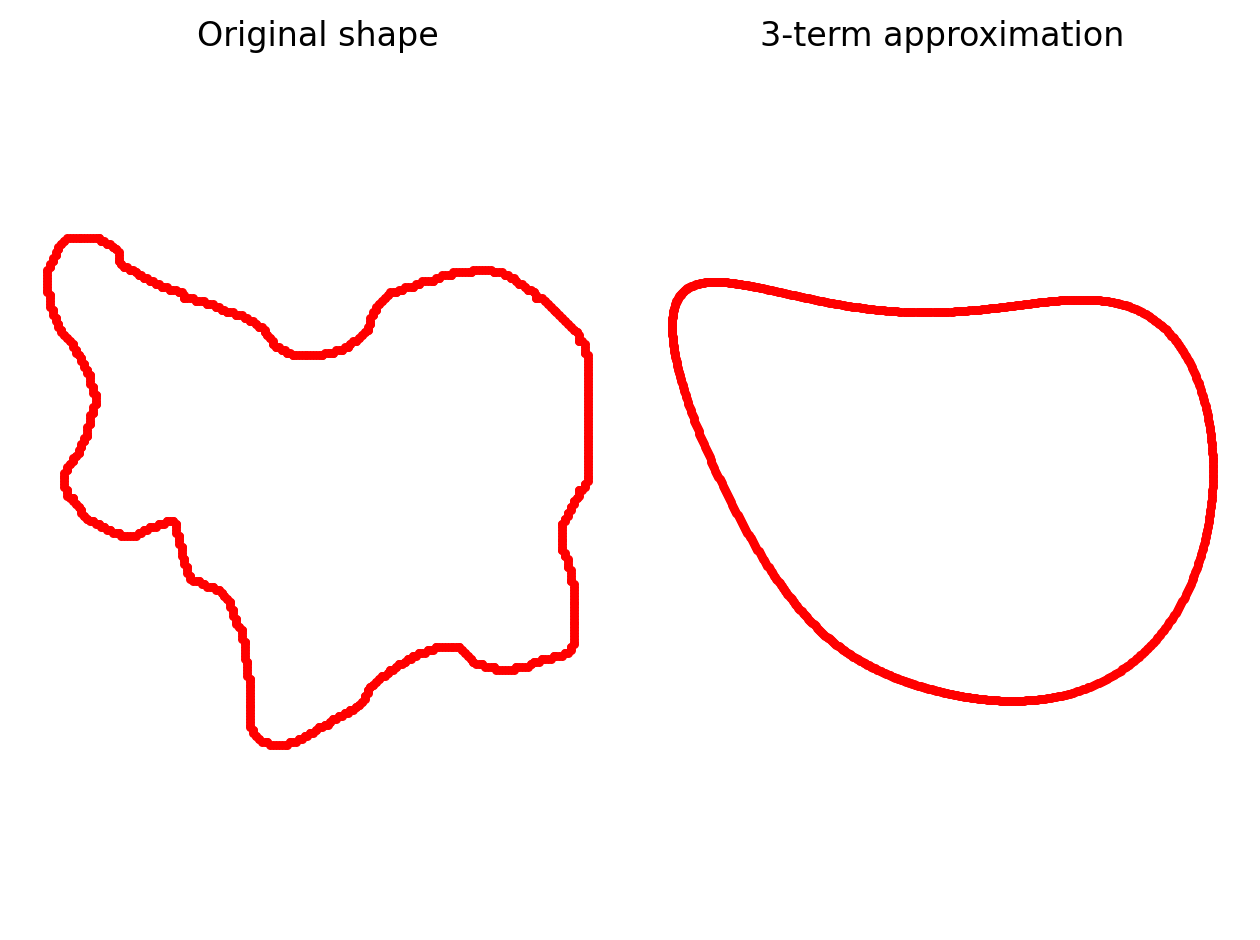

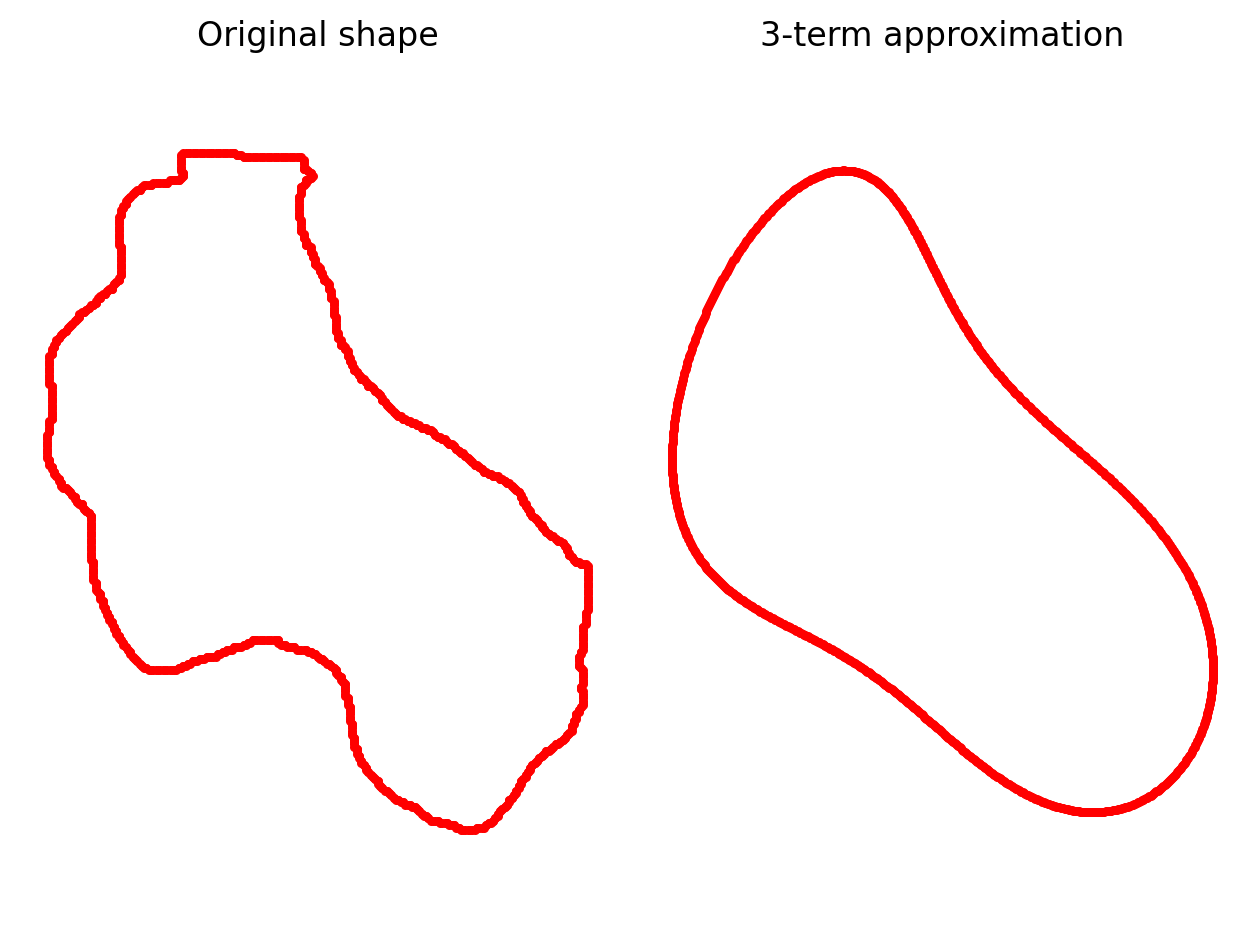

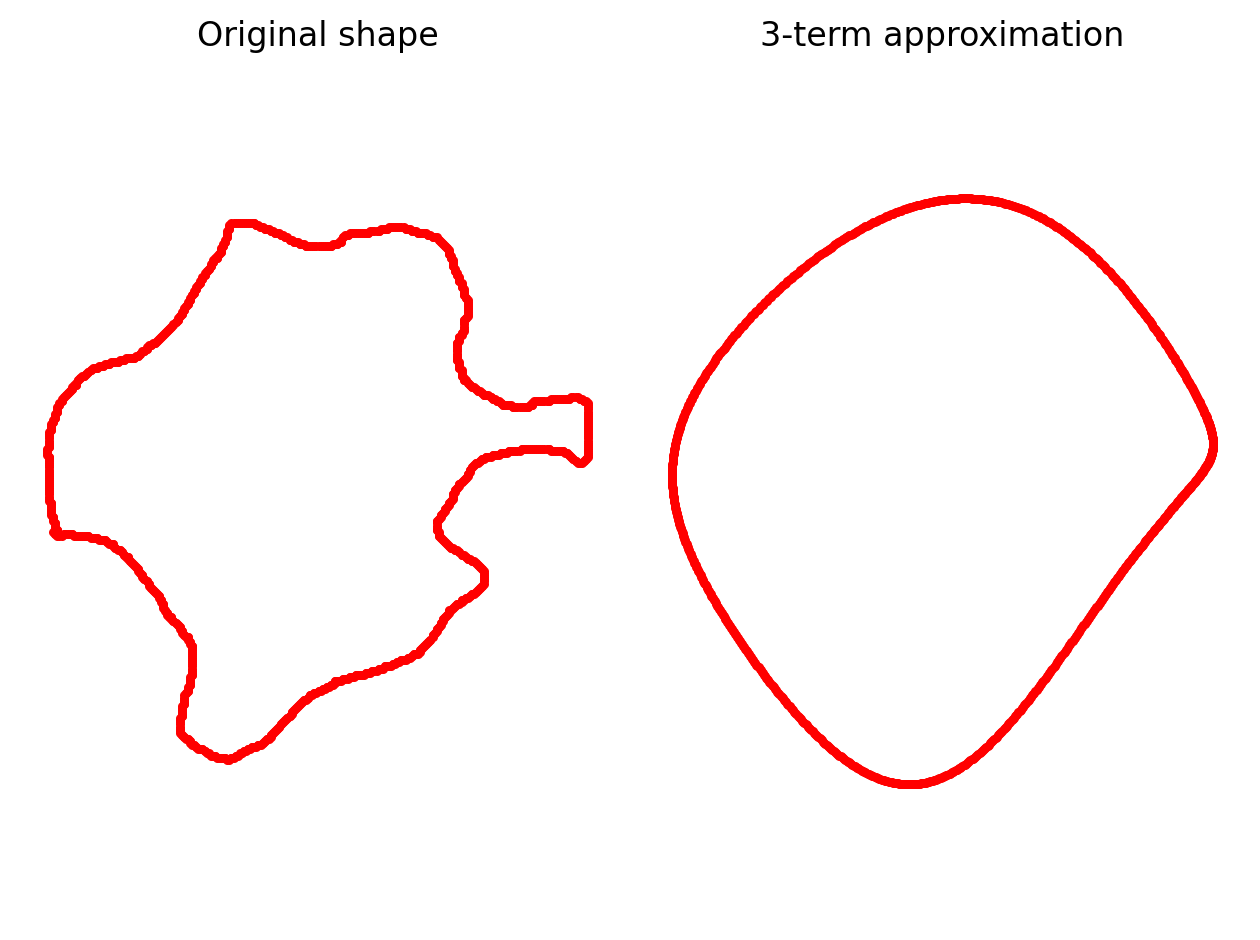

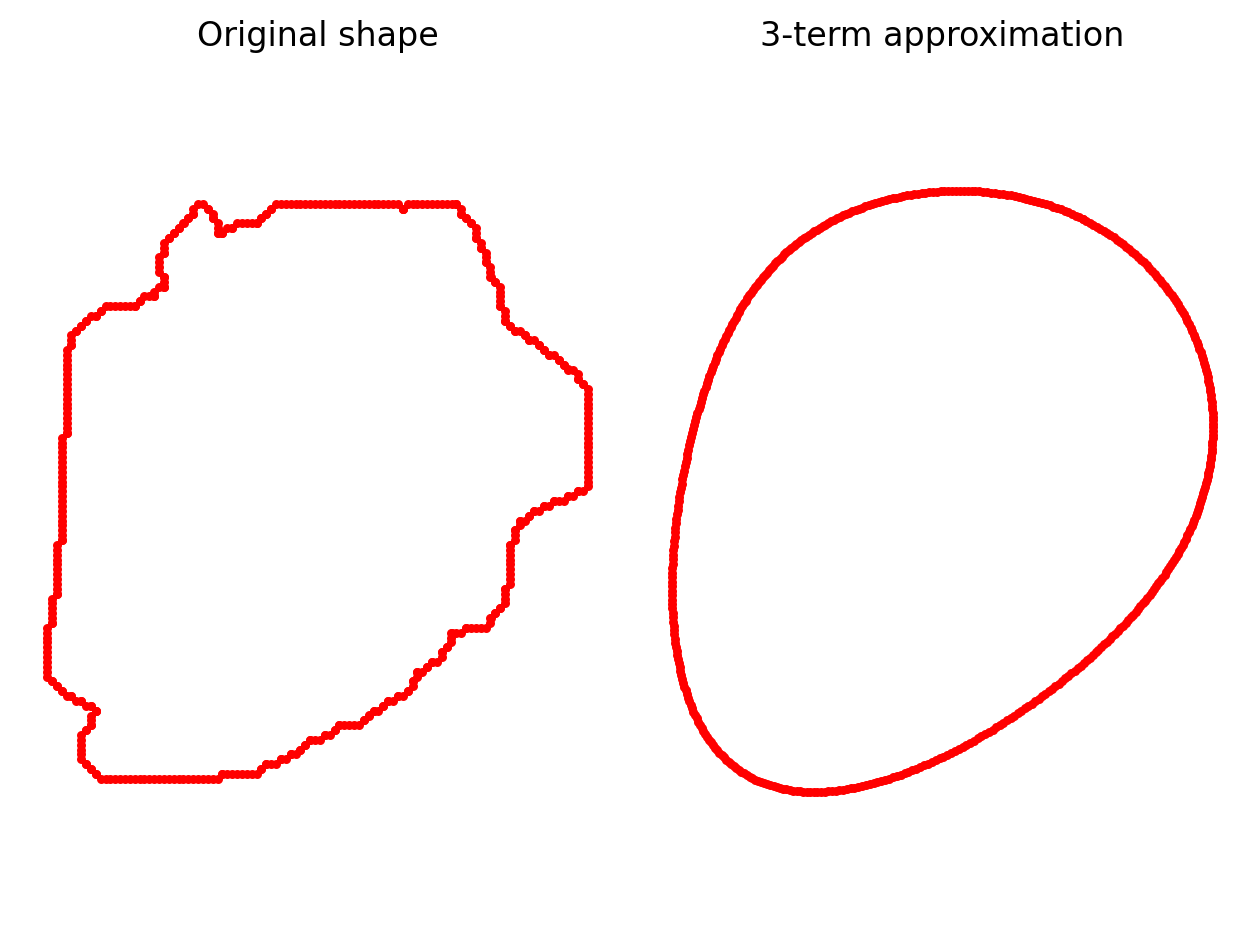

In [15]:
N = 3 # Try out different values such as 3, 5, 10, 15...

for idx in bbbc020_instances.keys():
    mask = bbbc020_instances[idx]
    
    # Retreive instance contour
    outline = skm.find_contours(mask,1)
    outline = outline[0]
    
    # Decompose into the Fourier basis
    (A0,C0) = pyefd.calculate_dc_coefficients(outline)
    fourier_coefficients = pyefd.elliptic_fourier_descriptors(outline, order = N)
    
    # Reconstruct
    n_term_approximation = pyefd.reconstruct_contour(fourier_coefficients, locus = (A0, C0), num_points = len(outline))
    
    # Visualize the result
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    axes[0].scatter(outline[:,1], outline[:,0], s = 5, c = 'red')
    axes[0].axis('equal')
    axes[0].axis('off')
    axes[0].set_title("Original shape")

    axes[1].scatter(n_term_approximation[:,1], n_term_approximation[:,0], s = 5, c = 'red')
    axes[1].axis('equal')
    axes[1].axis('off')
    axes[1].set_title(str(N)+"-term approximation")
    
    fig.tight_layout()
    plt.show()
    
# As we increase N, we recover more details in the approximation. 
# The first fourier coefficients capture a "low-pass" (or smoothed) version of the shape, while further 
# coefficients capture finer details.
    

**3.3** When *C. elegans* worms die, they rigidify into a straight rod. Even in the absence of the extra fluorescence microscopy readout, we could therefore still try to assess whether the *C. elegans* worms in the BBBC010 image are alive or not. Adapt 3.1 to use measurements from the list of region properties that you think are appropriate to capture the "straight" shape phenotype, and study the population of worms in the BBBC010 image using only the brightfield data. Do you manage to reach the same conclusion as in 2.2?

In [16]:
bbbc010_shape_feats = []
for idx in bbbc010_instances.keys():
    mask = bbbc010_instances[idx]
    
    all_props = skm.regionprops(mask)[0]
    bbbc010_shape_feats.append([all_props['area'], all_props['perimeter'], all_props['axis_major_length'],
                        all_props['axis_minor_length'], all_props['eccentricity'], all_props['solidity'],
                        all_props['extent']])

bbbc010_shape_feats = pd.DataFrame(bbbc010_shape_feats, columns=['Area', 'Perimeter', 'Major axis', 'Minor axis',
                                                 'Eccentricity', 'Solidity', 'Extent'])
bbbc010_shape_feats.index.name = 'Instance ID'

display(bbbc010_shape_feats)

,Area,Perimeter,Major axis,Minor axis,Eccentricity,Solidity,Extent
Instance ID,,,,,,,
0,1204,291.462987,124.191190,39.564507,0.947897,0.453313,0.203516
1,928,227.622366,105.010429,21.287854,0.979236,0.560048,0.193818
2,874,238.835570,103.339233,19.107361,0.982757,0.520858,0.193106
3,1039,260.237590,110.035513,37.397900,0.940472,0.348074,0.206151
4,845,246.846717,120.990986,13.713083,0.993556,0.666930,0.293913
5,1065,295.219300,146.437382,10.908250,0.997222,0.747893,0.462240
6,1190,268.977705,123.619279,26.690856,0.976413,0.480226,0.175361
7,1283,284.918831,134.443296,20.872129,0.987875,0.567699,0.154281
8,994,237.036580,61.393313,49.230843,0.597468,0.529005,0.398237


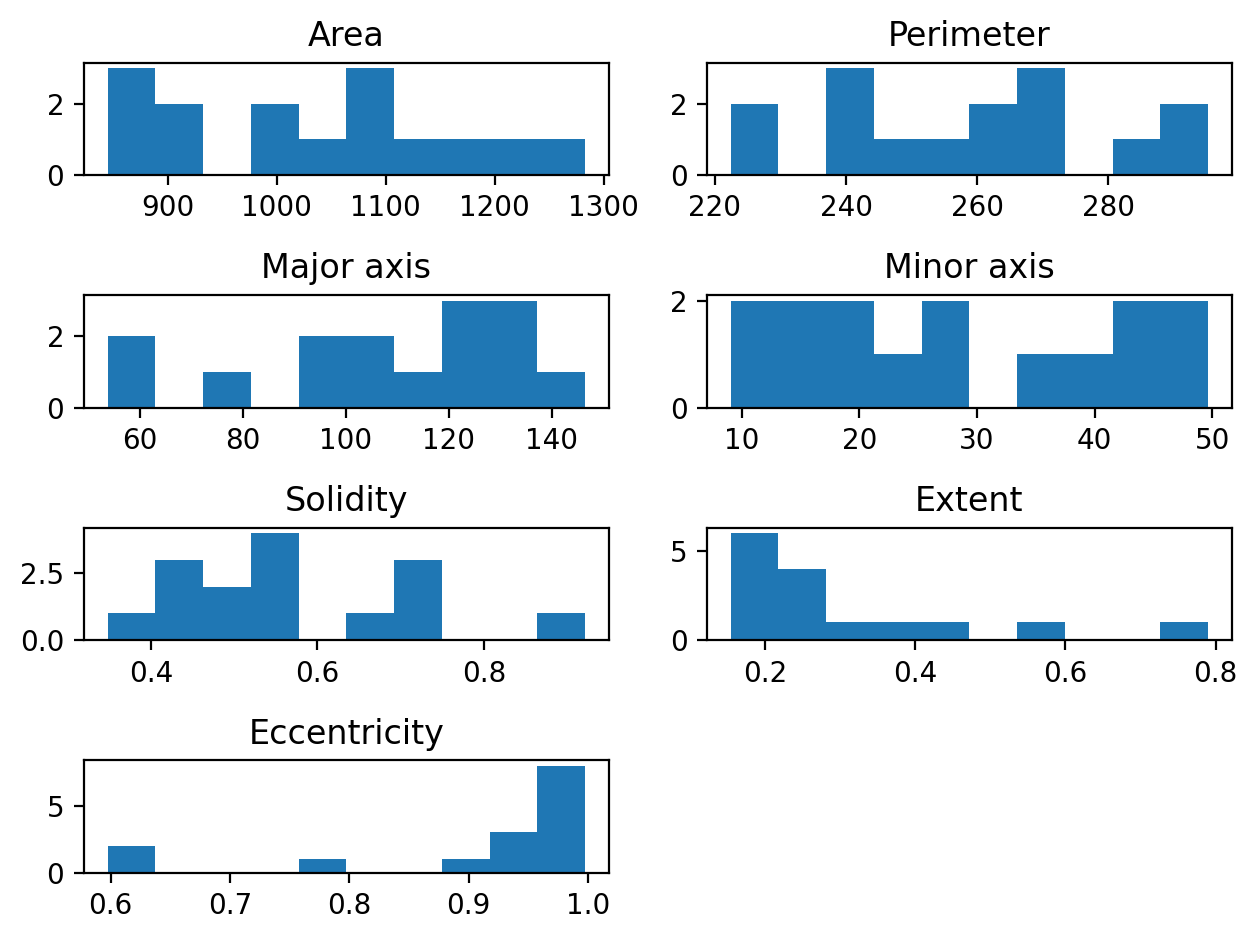

In [17]:
# Visualize the distribution of each feature as an histogram
fig, axes = plt.subplots(nrows=4, ncols=2)

axes[0,0].hist(bbbc010_shape_feats['Area'].values)
axes[0,0].set_title('Area')

axes[0,1].hist(bbbc010_shape_feats['Perimeter'].values)
axes[0,1].set_title('Perimeter')

axes[1,0].hist(bbbc010_shape_feats['Major axis'].values)
axes[1,0].set_title('Major axis')

axes[1,1].hist(bbbc010_shape_feats['Minor axis'].values)
axes[1,1].set_title('Minor axis')

axes[2,0].hist(bbbc010_shape_feats['Solidity'].values)
axes[2,0].set_title('Solidity')

axes[2,1].hist(bbbc010_shape_feats['Extent'].values)
axes[2,1].set_title('Extent')

axes[3,0].hist(bbbc010_shape_feats['Eccentricity'].values)
axes[3,0].set_title('Eccentricity')

axes[3,1].axis('off')

fig.tight_layout()
plt.show()

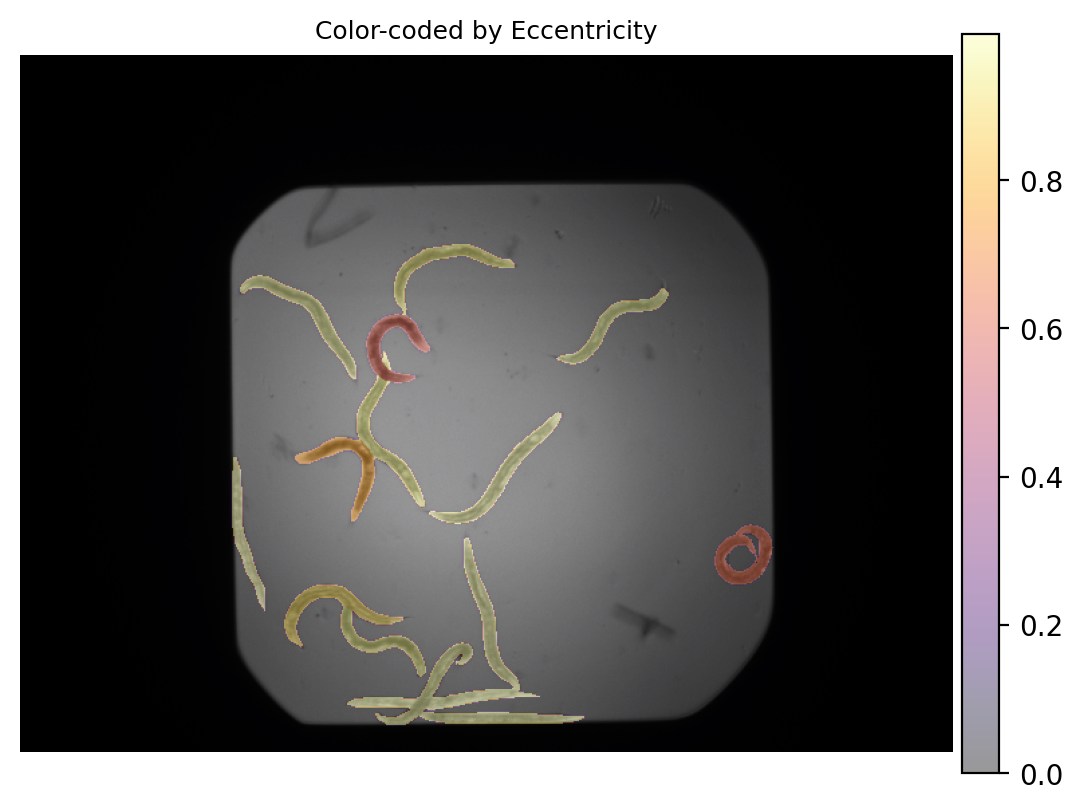

In [18]:
# It could be that dead worm scan be spotted by their low eccentricity?
feature = 'Eccentricity'

feature_mask = np.zeros(bbbc010.shape)
for idx in bbbc010_instances.keys():
    mask = bbbc010_instances[idx]
    
    feature_val = bbbc010_shape_feats.loc[idx, feature]
    feature_mask[np.where(mask)] = feature_val

plt.imshow(bbbc010, cmap='gray')
im = plt.imshow(feature_mask, cmap='inferno', alpha=.4) # Unfortunately not! These are not the right ones.
plt.colorbar(im, fraction=0.05, pad=0.01)
plt.axis('off')
plt.title('Color-coded by '+feature, fontsize=9)
plt.show()

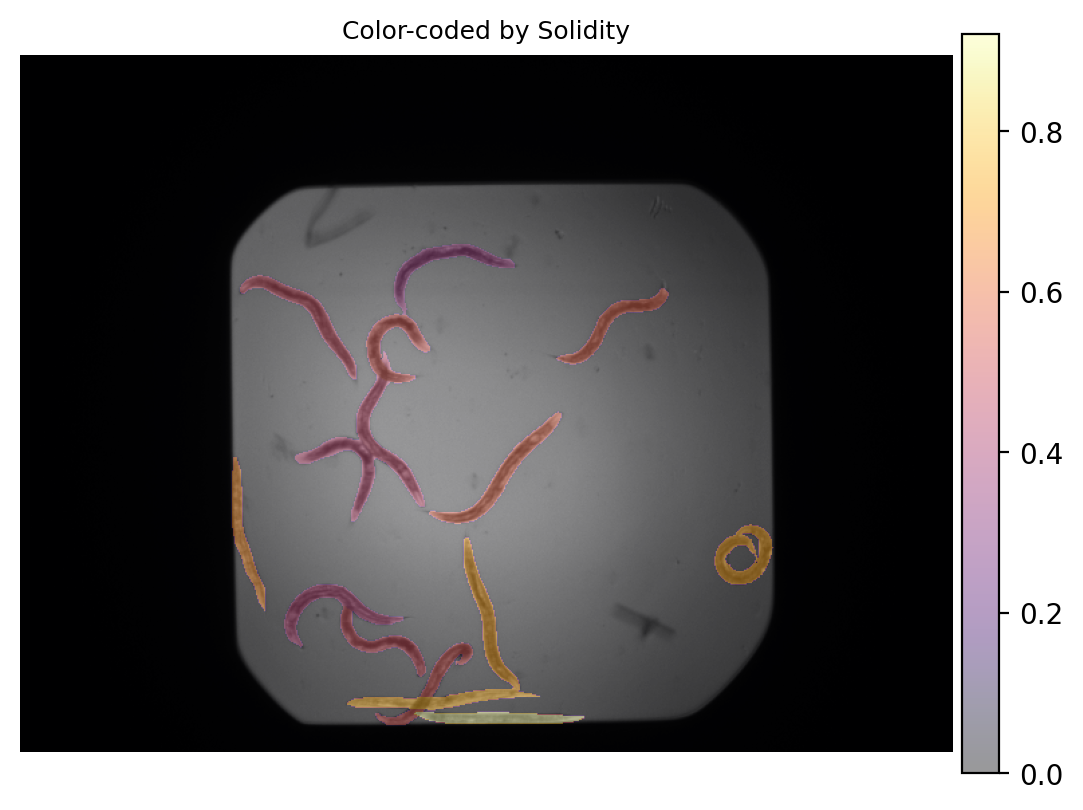

In [19]:
# Or maybe high solidity?
feature = 'Solidity'

feature_mask = np.zeros(bbbc010.shape)
for idx in bbbc010_instances.keys():
    mask = bbbc010_instances[idx]
    
    feature_val = bbbc010_shape_feats.loc[idx, feature]
    feature_mask[np.where(mask)] = feature_val

plt.imshow(bbbc010, cmap='gray')
im = plt.imshow(feature_mask, cmap='inferno', alpha=.4) # Better, but not quite precise enough
plt.colorbar(im, fraction=0.05, pad=0.01)
plt.axis('off')
plt.title('Color-coded by '+feature, fontsize=9)
plt.show()

# Bottom line: it is very hard to find a single shape feature that captures the "straight" phenotype!

## 4. Export

A collection of measurements describing an object as it appears on image data is referred to as a *feature vector*. Feature vectors are the basic ingredient of data analysis: they allow to use the visual information contained in images in statistical studies.

**4.1** Run the lines below to assemble all the intensity (2.2) and shape (3.3) measurements you have extracted on each object of the BBBC010 image into one big matrix.

In [20]:
feature_matrix = pd.concat([bbbc010_intensity_feats, bbbc010_shape_feats], axis=1)

display(feature_matrix)

,Median,Standard Deviation,Area,Perimeter,Major axis,Minor axis,Eccentricity,Solidity,Extent
Instance ID,,,,,,,,,
0,0.000214,0.000097,1204,291.462987,124.191190,39.564507,0.947897,0.453313,0.203516
1,0.000183,0.000077,928,227.622366,105.010429,21.287854,0.979236,0.560048,0.193818
2,0.000122,0.000160,874,238.835570,103.339233,19.107361,0.982757,0.520858,0.193106
3,0.000214,0.000322,1039,260.237590,110.035513,37.397900,0.940472,0.348074,0.206151
4,0.000916,0.000622,845,246.846717,120.990986,13.713083,0.993556,0.666930,0.293913
5,0.000412,0.000283,1065,295.219300,146.437382,10.908250,0.997222,0.747893,0.462240
6,0.000183,0.000078,1190,268.977705,123.619279,26.690856,0.976413,0.480226,0.175361
7,0.000168,0.000068,1283,284.918831,134.443296,20.872129,0.987875,0.567699,0.154281
8,0.000183,0.000071,994,237.036580,61.393313,49.230843,0.597468,0.529005,0.398237


**4.2** Run the line below to save the *feature matrix* you compiled into a spreadsheet. This file now quantitatively summarizes the content of the fluorescence and brightfield image and can be used for futher analysis.

In [21]:
feature_matrix.to_csv('data/Part 3/bbbc010_features.csv')